# RESULTS ANALYSIS OF THE  REVERBERATION EXPERIMENT

In [1]:
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from scipy.stats import *
from scipy.special import inv_boxcox
import math
from pychoacoustics import pysdt
import numpy as np
import pingouin as pg
import itertools
import statistics
from sklearn.metrics import confusion_matrix

Z = norm.ppf
PHI = norm.cdf
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

bin_h = 60
fv_h = 200
wro_h = 0
cor_h = 120

base_s = 60
base_v = 75
base_a = 1

alpha = .05

## Read Data

In [278]:
results_folder = 'test_dataframes'
exp_data = pd.read_csv(os.path.join(results_folder, 'experiment.csv'))
preliminary_data = pd.read_csv(os.path.join(results_folder, 'preliminary.csv'))
subject_data = pd.read_csv(os.path.join(results_folder, 'subject_info.csv'))

## Preprocess data

In [132]:
complexities = list(np.sort(exp_data['complexity'].unique()))
rooms = list(exp_data['room'].unique())
conditions = list(exp_data['condition'].unique())

rooms_lbl = {'Overall': 'Overall', 'LIVING_ROOM': 'Living room', 'METU': 'Classroom', '3D_MARCO': 'Auditorium'}
conditions_lbl = {'NONE': 'None', 'HOA_Bin': 'Bin', 'Freeverb': 'Freeverb'}

In [4]:
def generate_alluvial(src_idx, trg_idx, link_vals, link_lbls, link_cols, labels, cols, x_pos, y_pos, pad=5):
    sank = go.Sankey(
    arrangement='snap',
    valueformat = ".2f",
    valuesuffix = "%",
    # Define nodes
    node = dict(
        pad = pad,
        thickness = 10,
        line = dict(color = "black", width = 0.5),
        label =  labels,
        color =  cols,
        x = x_pos,
        y = y_pos,
    ),
    # Add links
    link = dict(
      source =  src_idx,
      target =  trg_idx,
      value =  link_vals,
      label =  link_lbls,
      color =  link_cols
    ))
    
    return sank

def overall_analysis(y_bin, y_fv, paired, chance_lvl=0.5, alpha=.05):
    y_bin = np.array(y_bin)
    y_fv = np.array(y_fv)
    
    res_bin = pg.normality(y_bin, alpha=alpha)
    print(f'Normality Bin: {res_bin.normal.values[0]} (p: {res_bin.pval.values[0]})')

    res_fv = pg.normality(y_fv, alpha=alpha)
    print(f'Normality Freeverb: {res_fv.normal.values[0]} (p: {res_fv.pval.values[0]})')
            
    
    if res_bin.normal.values[0] & res_fv.normal.values[0]:
        print('\nt-test')
        
        res_bin_fv = pg.ttest(y_bin, y_fv, paired=paired)

        if chance_lvl is not None:
            res_bin_chn = pg.ttest(y_bin, chance_lvl)

            res_fv_chn = pg.ttest(y_fv, chance_lvl)

    else:
        print('\nWilcoxon')
        
        if paired:
            res_bin_fv = pg.wilcoxon(y_bin, y_fv)
        else:
            res_bin_fv = pg.mwu(y_bin, y_fv)

        if chance_lvl is not None:
            res_bin_chn = pg.wilcoxon(y_bin - chance_lvl)

            res_fv_chn = pg.wilcoxon(y_fv - chance_lvl)
            
        
    print('\nBin == Freeverb' if res_bin_fv['p-val'][0] > alpha else '\nBin != Freeverb')
    print(res_bin_fv)
    
    if chance_lvl is not None:
        print(f'\nBin == {chance_lvl}' if res_bin_chn['p-val'][0] > alpha else f'\nBin != {chance_lvl}')
        print(res_bin_chn)

        print(f'\nFreeverb == {chance_lvl}' if res_fv_chn['p-val'][0] > alpha else f'\nFreeverb != {chance_lvl}')
        print(res_fv_chn)

## Subjects Data

In [ ]:
subject_data

In [ ]:
fig = px.histogram(subject_data, x="sex", title='Sex distribution')
fig.show()

fig = px.histogram(subject_data, x="age", title='Age range distribution')
fig.show()

fig = px.histogram(subject_data, x="reverberation", title='Experience on reverberation distribution')
fig.show()

fig = px.histogram(subject_data, x="vr", title='Experience on VR distribution')
fig.show()

fig = px.histogram(subject_data, x="impairment", title='Hearing impairment distribution')
fig.show()

fig = px.histogram(subject_data, x="duration", title='Experiment duration distribution')
fig.show()

Discarded subjects

In [101]:
subject_data[subject_data.subject_progressive_id.isin(no_subj)]

subject_matlab_id  subject_progressive_id    age     sex reverberation  \
1                   2                       1  18-27    Male          None   
10                 11                      10  18-27  Female          None   
19                 24                      19  18-27    Male          None   
28                 30                      28  28-37  Female          None   
30                 32                      30  18-27    Male  Intermediate   

              vr impairment  duration  \
1           None         No        60   
10          None         No        43   
19          None         No        37   
28        Expert         No        49   
30  Intermediate         No        90   

                                                                                identification_strategy  \
1   Ascoltare singolarmente e identificare chi aveva più/meno riverbero. Se simili erano nella stess...   
10  A volte intensità del suono o collocazione diversa nello spazio ha influenzato.Più consapevolezz...   
19                Cercava chi aveva un riverbero diverso. Aspettare quando uno speaker parlava da solo.   
28  2 strategie. 1) quello fuori posto a sensazione 2) poi cercato di sentire i riverberi di ognuno ...   
30                      Stimare quanto si diffondono le voci e qaunto riverbero. Dove sono nella stanza   

                                                                                             confidence  \
1                                                     A volte non sicurissimo ma a spesso molto sicuro.   
10                                                 Livello di confidenza basso per quasi tutto il test.   
19                                   Bassa confidenza nelle risposta. Ragazze quasi coperte dai maschi.   
28  Confidenza medio-alta. auditorium più difficile, mentre living room più semplice. metu nel mezzo...   
30                                                          80% di confidenza, non completamente sicuro   

                             vr_sickness  \
1   Peso visore dopo un po' dà problemi.   
10                       No problemi VR.   
19  No problemi VR. Voci sovrapposte sì.   
28                       No problemi VR.   
30                                    No   

                                                                                         other_comments  
1              Dichiarata una curva di apprendimento. Più complicato classificare con solo due persone.  
10                                            Pensa di aver avuto troppe poche informazioni all'inizio.  
19  Volume troppo alto. NDA: ha risposto molto velocemente soprattutto verso la fine. Ha detto che d...  
28                                                                                                  NaN  
30                                                                        Con 4 voci confuso. stancante

## Preliminary Experiment

In [102]:
def plot_preliminary(df, add_overall=True):
    groups_names = ['condition', 'room', 'speaker']

    for group_name in groups_names:
        fig = go.Figure()

        if add_overall:
            trace = go.Histogram(histnorm='percent')
            trace.name = 'Overall'
            trace.x = df['externalization']
            fig.add_trace(trace)

        for name, group in df.groupby(group_name):
            trace = go.Histogram(histnorm='percent')
            trace.name = name
            trace.x = group['externalization']
            fig.add_trace(trace)

        fig.update_layout(
            title_text=group_name.upper(),
            yaxis_title_text='%',
#             width=300,
#             height=400
        )
        fig.update_xaxes(categoryorder='array', categoryarray= ['Inside', 'Edge', 'Outside'])

        fig.show()

### Preliminary Experiment -  Overall

Remove the first 3 trials of the preliminary experiment for each subject (hidden training)

In [97]:
# preliminary_data_filt = preliminary_data[preliminary_data['trial_id_per_subject'] > 3]

In [103]:
plot_preliminary(preliminary_data, add_overall=False)

Remove the subject that rated the Ref as Inside more than 2 times

In [109]:
# Lower bound of the number of Inside responses given to Ref for each subject
ins_lim = 2

s_ref_ext = preliminary_data[preliminary_data.condition == 'Ref'].groupby('subject_progressive_id')['externalization'].value_counts()
s_excl = s_ref_ext[(s_ref_ext.index.get_level_values(1) == 'Inside') & (s_ref_ext >= ins_lim)]

no_subj = list(s_excl.index.get_level_values(0).values)
preliminary_data_filt = preliminary_data[~preliminary_data.subject_progressive_id.isin(no_subj)]

print(f'Discarded subjects: {no_subj}')
print(f'N. subjects considered: {preliminary_data_filt.subject_progressive_id.nunique()}')

Discarded subjects: [1, 10, 19, 28, 30]
N. subjects considered: 26


In [107]:
plot_preliminary(preliminary_data_filt, add_overall=False)

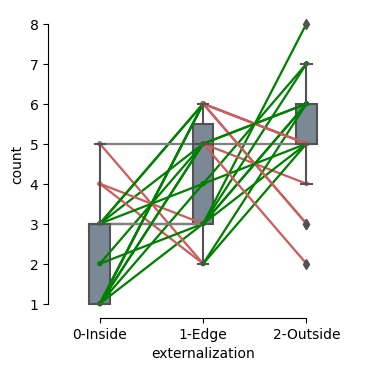

In [108]:
s_ext = preliminary_data_filt.groupby('subject_progressive_id')['externalization'].value_counts()
df_ext = s_ext.index.to_frame(index=False)
df_ext.externalization.replace({'Inside': '0-Inside', 'Edge': '1-Edge', 'Outside': '2-Outside'}, inplace=True)
df_ext['count'] = s_ext.values
ax = pg.plot_paired(data=df_ext, dv='count', within='externalization', subject='subject_progressive_id')

### Preliminary Experiment -  Males

Keep only males (the greater group)

In [ ]:
preliminary_data_filt_male = preliminary_data_filt[
    preliminary_data_filt.subject_progressive_id.isin(subject_data[subject_data.sex=='Male'].subject_progressive_id)]

In [ ]:
plot_preliminary(preliminary_data_filt_male)

## Experiment Results

Decide if remove the subjects screened in the preliminary experiment

In [280]:
remove_subjects = True

if remove_subjects:
    exp_data_all_subj = exp_data.copy(deep=True)
    exp_data = exp_data[~exp_data.subject_progressive_id.isin(no_subj)]
    
n_trials_tot = exp_data.shape[0]
# 'impostor_correct_answer' = NaN when subject answered 'Yes, they are all in the same room'
exp_data_imp_adj = exp_data.copy(deep=True)
exp_data_imp_adj.loc[exp_data_imp_adj.same_room_answer == 'Yes', 'impostor_correct_answer'] = float('nan')


print(f'N. subjects considered: {exp_data.subject_progressive_id.nunique()}')
exp_data.subject_progressive_id.unique()

N. subjects considered: 26


array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18,
       20, 21, 22, 23, 24, 25, 26, 27, 29], dtype=int64)

### Count identification response occurrencies

#### Bar plots

In [116]:
def plot_count(exp_data, rooms, complexities, col_to_count, col_stack, path=None, perc_cols=None):
    g_cols = [col_stack, col_to_count]
    rooms_lbl = {'LIVING_ROOM': 'Living room',
                 'METU': 'Classroom',
                 '3D_MARCO': 'Auditorium'}
    
    for room, compl in itertools.product(rooms, complexities):
        df = exp_data[(exp_data['room'] == room) &
                            (exp_data['complexity'] == compl)]
        count_df = df[g_cols].groupby(g_cols).size()
        count_df.name = 'count'
        count_df = count_df.reset_index()
        
        if perc_cols is not None:
            
            for v in count_df[col_to_count].unique():
                if v == 'NONE':
                    n_v = df.shape[0]
                else:
                    n_v = sum((df['speaker1'] == v) | (df['speaker2'] == v) | (df['speaker3'] == v) | (df['speaker4'] == v))

                count_df.loc[count_df[col_to_count]==v, 'count'] = count_df.loc[count_df[col_to_count]==v, 'count'] / n_v
                

        count_df0 = count_df[count_df[col_stack] == 0]
        count_df1 = count_df[count_df[col_stack] == 1]

        fig = go.Figure(data=[
            go.Bar(name='Correct identification', x=count_df1[col_to_count], y=count_df1['count']),
            go.Bar(name='Wrong identification', x=count_df0[col_to_count], y=count_df0['count'])
        ])

        fig.update_layout(barmode='stack',
                          title=f'{rooms_lbl[room]} - Complexity {compl}',
                          xaxis_title="Position",
                          yaxis_title="Count" if perc_cols is None else "Percentage %",)
        
        fig.update_xaxes(categoryorder='total descending')

        fig.show()
        
        if path is not None:
            with open(path, 'a') as f:
                f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))

Plot the occurrencies of the positions in the subject's answers for each room and for each complexity

In [117]:
cor_iden_col = 'impostor_correct_answer'
pos_ans_col = 'position_answer'

plot_count(exp_data, rooms, complexities, col_to_count=pos_ans_col, col_stack=cor_iden_col,
          path='position_count.html')

Plot the occurencies of the speakers in the subject's answers for each room and for each complexity. The number of occurencies for each speaker is divided by the number of times each speaker was present in the trials for each room and complexity.

In [118]:
cor_iden_col = 'impostor_correct_answer'
speaker_ans_col = 'speaker_answer'
perc_cols = ['speaker1','speaker2','speaker3','speaker4']

plot_count(exp_data, rooms, complexities, col_to_count=speaker_ans_col, col_stack=cor_iden_col,
           path='speaker_count.html', perc_cols=perc_cols)

#### Confusion Matrix

##### Positions

In [119]:
lbl_pos = {}
lbl_pos['LIVING_ROOM'] = ['NONE', 'SG4', 'S5', 'STV', 'SG6']
lbl_pos['METU'] = ['NONE', '032', '302', '152', '112']
lbl_pos['3D_MARCO'] = ['NONE', '-30', '+90', '0', '+30']

for r in rooms:
    exp_data_r = exp_data[exp_data['room'] == r]

    cm = confusion_matrix(exp_data_r['position_impostor'], exp_data_r['position_answer'], labels=lbl_pos[r],  normalize='true')

#     # Add tot column
#     actual_sum = cm.sum(axis=1)
#     # response_sum = cm.sum(axis=0)
#     cm = np.hstack((cm, np.expand_dims(actual_sum, axis=1)))
#     # # np.vstack((cm, np.expand_dims(response_sum, axis=0)))
#     # cm_norm = (cm.T / actual_sum).T
#     lbl_pos_tot = lbl_pos[r] + ['Tot']
    
    # Round
    cm = np.ndarray.round(cm*100, decimals=1)

    fig = px.imshow(cm, x=lbl_pos[r], y=lbl_pos[r], color_continuous_scale='Viridis')
    fig.update_layout(title=f'Confusion matrix position - {rooms_lbl[r]}',
                     yaxis_title="Actual position ",
                     xaxis_title="Response position")
    fig.update_traces(text=cm, texttemplate="%{text}%")
    fig.update_xaxes(side="top")
    fig.show()

##### Speakers

In [120]:
lbl_speak = ['NONE', 'ALEX', 'DAVID', 'MARIA', 'SUSAN']

# for r in rooms:
# exp_data_r = exp_data[exp_data['room'] == r]

cm = confusion_matrix(exp_data['speaker_impostor'], exp_data['speaker_answer'], labels=lbl_speak)#,  normalize='true')
cm = cm.astype(float)

for i, s_a in enumerate(lbl_speak):
    for j, s_r in enumerate(lbl_speak):
        if (s_a == 'NONE') & (s_r == 'NONE'):
            n_v = exp_data.shape[0]
        elif (s_a == s_r) | (s_r == 'NONE'):
            n_v = sum(exp_data['speaker_impostor'] == s_a)
        else:
            n_v = sum(
                (exp_data['speaker_impostor'] == s_a) & 
                ((exp_data['speaker1'] == s_r) | (exp_data['speaker2'] == s_r) | (exp_data['speaker3'] == s_r) | (exp_data['speaker4'] == s_r))
            )

        cm[i,j] = cm[i,j] / n_v

# Round
cm = np.ndarray.round(cm*100, decimals=1)

fig = px.imshow(cm, x=lbl_speak, y=lbl_speak, color_continuous_scale='Viridis')
fig.update_layout(title=f'Confusion matrix speakers',
                 yaxis_title="Actual speaker",
                 xaxis_title="Response speaker")
fig.update_traces(text=cm, texttemplate="%{text}%")
fig.update_xaxes(side="top")
fig.show()

#### Alluvial plots

In [121]:
def plot_alluvial_pos(df,
                  src_col,
                  trg_col,
                  title='Alluvial plot',
                  percentage=True,
                  return_fig=False,
                  save_to=None):
    
    n_trials_tot = df.shape[0]
    
    src_vals = sorted(list(df[src_col].unique()))
    trg_vals = sorted(list(df[trg_col].unique()))
    # Put NONE at the front of the lists
    src_vals.insert(0, src_vals.pop(src_vals.index('NONE')))
    trg_vals.insert(0, trg_vals.pop(trg_vals.index('NONE')))
    
    src_lbls = src_vals.copy()
    
    src_vals_no_none = src_lbls[1:]
    for v in src_vals_no_none:
        val = df[df[src_col] == v]['condition'].values[0]
        if val == 'HOA_Bin':
            val = 'Bin'
        src_lbls[src_lbls.index(v)] = v + '(' + val + ')'
        
        
    labels = src_lbls + trg_vals
    
    src_idx = []
    trg_idx = []
    link_vals = []
    for s in range(len(src_vals)):
        for t in range(len(trg_vals)):
            sel = ((df[src_col] == src_vals[s]) & (df[trg_col] == trg_vals[t]))
            
            val = sel.sum() / n_trials_tot
#             print(f'{sel.sum()} / {n_trials_tot} = {val} ({src_vals[s]} {s}, {trg_vals[t]} {len(src_vals) + t})')
            
            src_idx.append(s)
            trg_idx.append(len(src_vals) + t)
            link_vals.append(val)
            
    # COLORS
    op = 0.35
    step = 15
    
    h_step = 50
    h1 = 30
    
    saturations = [base_s] * len(trg_vals)
    values = [base_v] * len(trg_vals)
    cols = []
    link_cols = []

    col_pos = dict.fromkeys(src_vals, '')
    
    for c in range(len(src_vals)):
        col_pos[src_vals[c]] = f'hsva({h_step * c + h1}, {saturations[c]}, {values[c]+step}, {op})'
        cols.append(col_pos[src_vals[c]])

        for sub in range(len(trg_vals)):
            col = f'hsva({h_step * c + h1}, {saturations[c]}, {values[c]}, {op})'
            link_cols.append(col)
        
    for c in range(len(trg_vals)):
        if trg_vals[c] not in col_pos.keys():
            cols.append(f'hsva({h_step * (c + len(src_vals)) + h1}, {saturations[c]}, {values[c]}, {op})')
        else:
            cols.append(col_pos[trg_vals[c]])

#     print(labels)
#     trg_node_pos_noise = sum([link_vals[i] for i, t in enumerate(trg_idx) if t==noise_idx])/2
#     trg_node_pos_signal = trg_node_pos_noise*2 + sum([link_vals[i] for i, t in enumerate(trg_idx) if t==sig_id])/2
    x_pos = [0] * len(src_vals) + [1] * len(trg_vals)
    y1 = list(np.linspace(0,1,len(src_vals)+1))
    y2 = list(np.linspace(0,1,len(trg_vals)+1))
    y_pos = y1[:-1] + y2[:-1]
#     print(x_pos)
#     print(y_pos)
#     print(src_vals)
#     print(src_idx)
#     print(trg_vals)
#     print(trg_idx)
    
    
    sank = generate_alluvial(src_idx, trg_idx, link_vals,
                             link_lbls=None, link_cols=link_cols,
                             labels=labels, cols=cols,
                             x_pos=x_pos, y_pos=y_pos)

    if return_fig:
        return sank
    
    fig = go.Figure(data=[sank])
    fig.update_layout(title_text=title,
                      font_size=15)
    
    fig.show()
    
    if save_to is not None:
        fig.write_html(save_to)


In [122]:
fig = make_subplots(rows=len(rooms), cols=len(complexities), start_cell="top-left",
                    specs=[[{"type": "sankey"} for n_c in range(len(complexities))] for n_r in range(len(rooms))],
#                     subplot_titles=[f'Complexity {c} - Room: {r}' for r in rooms_row_lbl for c in complexities],
                    column_titles=[f'Complexity {c}' for c in complexities],
                    row_titles =[f'{rooms_lbl[r]}' for r in rooms],
                   )

for c_idx, complexity in enumerate(complexities):        
    
    for r_idx, room in enumerate(rooms):

        df = exp_data[(exp_data['complexity'] == complexity) & (exp_data['room'] == room)]

        fig.add_trace(plot_alluvial_pos(df=df,
                                        src_col='position_impostor',
                                        trg_col='position_answer',
                                        title='',
                                        percentage=True,
                                        return_fig=True,
                                    ),
                      row=r_idx+1,
                      col=c_idx+1
                     )
#         plot_alluvial_pos(df=df,
#                                         src_col='position_impostor',
#                                         trg_col='position_answer',
#                                         title='',
#                                         percentage=True,
#                                         return_fig=False,
#                                     )
#         break
#     break

            

fig.update_layout(height=1024, title_text="Alluvial plots per complexity and per room")
fig.show()

fig.write_html('img_results/alluvial_compl_room_positions.html')

### Accuracies with bar plots

In [125]:
def plot_accuracies(res_df, groups_names):
    fig = go.Figure(data=[go.Bar(name='Yes', x=['Yes'],
                                 y=[(exp_data['same_room_answer'] == 'Yes').sum()/exp_data['same_room_answer'].count()]),
                          go.Bar(name='No', x=['No'],
                                 y=[(exp_data['same_room_answer'] == 'No').sum()/exp_data['same_room_answer'].count()])
                         ],
                    layout_yaxis_range=[0, 1]
                   )
    fig.update_layout(barmode='stack',
                     title_text='Percentage of Yes and No answers',
                     yaxis_title_text='%')
    fig.show()
    
    acc_names = ['Accuracy same room', 'Accuracy impostor']
    acc_cols = ['same_correct_answer', 'impostor_correct_answer']
    n_rows = res_df.shape[0]

    overall_bar = go.Bar(name='OVERALL', x=acc_names, y=[res_df[acc].sum()/res_df[acc].count() for acc in acc_cols])
    fig = go.Figure([overall_bar], layout_yaxis_range=[0, 1]) 

    fig.update_layout(
        title_text='Overall Accuracies',
        yaxis_title_text='%')
    fig.show()

    for group_name in groups_names:
        bar_data = [overall_bar]

        for name, group in res_df.groupby(group_name):
            bar_data.append(go.Bar(name=name, x=acc_names, y=[group[acc].sum()/group[acc].count() for acc in acc_cols]))
            
        fig = go.Figure(data=bar_data, layout_yaxis_range=[0, 1])

        fig.update_layout(
            title_text=group_name.upper(),
            yaxis_title_text='%')
        fig.show()
        
        # Sub conditions
        
        # Iterate on the fields different from the current field
        for group_sub in groups_names:
            if group_sub != group_name:
                
                group_sub_values = res_df[group_sub].unique()
                # Iterate on the values of the current field
                for group_val in group_sub_values:
                    
                    res_df_filt = res_df[res_df[group_sub] == group_val]
                    
                    overall_bar_sub = go.Bar(name=f"[{group_val}]OVERALL", x=acc_names, y=[res_df_filt[acc].sum()/res_df_filt[acc].count() for acc in acc_cols])
                    bar_data = [overall_bar_sub]

                    for name, group in res_df_filt.groupby(group_name):
                        bar_data.append(go.Bar(name=f"[{group_val}]{name}", x=acc_names, y=[group[acc].sum()/group[acc].count() for acc in acc_cols]))

                    fig = go.Figure(data=bar_data, layout_yaxis_range=[0, 1])

                    fig.update_layout(
                        title_text=f"[{group_sub.upper()}: {group_val}] {group_name.upper()}",
                        yaxis_title_text='%')
                    fig.show()

chi-squared or Fisher's exact test to assess difference between conditions? ANOVA should be used for continuous data, here we have binary data.

Accuracies plots having `impostor_correct_answer` = NaN when subject answered ''Yes, they are all in the same room''

In [ ]:
plot_accuracies(exp_data_imp_adj, ['condition', 'room', 'complexity', 'speaker_impostor'])

Accuracies plots having `impostor_correct_answer` = `same_correct_answer` when subject answered ''Yes, they are all in the same room'' (for STD analysis)

In [ ]:
plot_accuracies(exp_data, ['condition', 'room', 'complexity', 'speaker_impostor'])

### Statistical analysis

#### Analysis on subjects' detection answers

In [138]:
ind_var = 'condition'
dep_var = 'same_room_answer'

expected, observed, stats = pg.chi2_independence(exp_data, x=ind_var, y=dep_var)
stats

test    lambda       chi2  dof      pval    cramer     power
0             pearson  1.000000  24.383598  2.0  0.000005  0.186372  0.995772
1        cressie-read  0.666667  24.416107  2.0  0.000005  0.186496  0.995812
2      log-likelihood  0.000000  24.554923  2.0  0.000005  0.187025  0.995980
3       freeman-tukey -0.500000  24.724826  2.0  0.000004  0.187671  0.996175
4  mod-log-likelihood -1.000000  24.952645  2.0  0.000004  0.188534  0.996424
5              neyman -2.000000  25.589381  2.0  0.000003  0.190924  0.997038

chi2 is large when the there's a big difference between the observed and expected frequencies

If the obtained chi1 is greater than the chi2 critical value then the difference between the observed and expected frequencies is statistically significant

chi2 critical value = 5.99 (https://www.scribbr.com/statistics/chi-square-distribution-table/)

So, since 20.5 > 5.99 (p<.001) then the condition variable is related to the response variable (the frequency of Yes/No responses is not the same for all reverb conditions)

In [139]:
expected

same_room_answer     No    Yes
condition                     
Freeverb          126.0  108.0
HOA_Bin           126.0  108.0
NONE              126.0  108.0

In [140]:
observed

same_room_answer   No  Yes
condition                 
Freeverb          151   83
HOA_Bin           129  105
NONE               98  136

##### Post-hoc

In [141]:
alpha_bonf3 = alpha / 3

NONE vs. Bin

In [142]:
expected_nb, observed_nb, stats_nb = pg.chi2_independence(exp_data[exp_data[ind_var] != 'Freeverb'], x=ind_var, y=dep_var)
if stats_nb.iloc[0]['pval'] < alpha_bonf3:
    print(f'The difference between NONE and Bin is significant (p: {stats_nb.iloc[0]["pval"]:.5f})')
else:
    print(f'The difference between NONE and Bin is not significant (p: {stats_nb.iloc[0]["pval"]:.5f})')
    
stats_nb

The difference between NONE and Bin is significant (p: 0.00552)


test    lambda      chi2  dof      pval    cramer     power
0             pearson  1.000000  7.699198  1.0  0.005525  0.128263  0.792402
1        cressie-read  0.666667  7.703926  1.0  0.005510  0.128302  0.792645
2      log-likelihood  0.000000  7.720525  1.0  0.005460  0.128440  0.793499
3       freeman-tukey -0.500000  7.739270  1.0  0.005403  0.128596  0.794460
4  mod-log-likelihood -1.000000  7.763466  1.0  0.005331  0.128797  0.795694
5              neyman -2.000000  7.828455  1.0  0.005143  0.129335  0.798978

NONE vs. Freeverb

In [143]:
expected_nf, observed_nf, stats_nf = pg.chi2_independence(exp_data[exp_data[ind_var] != 'Bin'], x=ind_var, y=dep_var)
if stats_nf.iloc[0]['pval'] < alpha_bonf3:
    print(f'The difference between NONE and Freeverb is significant (p: {stats_nf.iloc[0]["pval"]:.5f})')
else:
    print(f'The difference between NONE and Freeverb is not significant (p: {stats_nf.iloc[0]["pval"]:.5f})')
    
stats_nf

The difference between NONE and Freeverb is significant (p: 0.00001)


test    lambda       chi2  dof      pval    cramer     power
0             pearson  1.000000  24.383598  2.0  0.000005  0.186372  0.995772
1        cressie-read  0.666667  24.416107  2.0  0.000005  0.186496  0.995812
2      log-likelihood  0.000000  24.554923  2.0  0.000005  0.187025  0.995980
3       freeman-tukey -0.500000  24.724826  2.0  0.000004  0.187671  0.996175
4  mod-log-likelihood -1.000000  24.952645  2.0  0.000004  0.188534  0.996424
5              neyman -2.000000  25.589381  2.0  0.000003  0.190924  0.997038

Bin vs. Freeverb

In [148]:
expected_bf, observed_bf, stats_bf = pg.chi2_independence(exp_data[exp_data[ind_var] != 'NONE'], x=ind_var, y=dep_var)
if stats_bf.iloc[0]['pval'] < alpha_bonf3:
    print(f'The difference between Bin and Freeverb is significant (p: {stats_bf.iloc[0]["pval"]:.5f})')
else:
    print(f'The difference between Bin and Freeverb is not significant (p: {stats_bf.iloc[0]["pval"]:.5f})')
    
stats_bf

The difference between Bin and Freeverb is not significant (p: 0.04769)


test    lambda      chi2  dof      pval    cramer     power
0             pearson  1.000000  3.920745  1.0  0.047694  0.091530  0.508068
1        cressie-read  0.666667  3.922161  1.0  0.047654  0.091546  0.508211
2      log-likelihood  0.000000  3.927127  1.0  0.047513  0.091604  0.508710
3       freeman-tukey -0.500000  3.932728  1.0  0.047355  0.091669  0.509274
4  mod-log-likelihood -1.000000  3.939948  1.0  0.047152  0.091753  0.509999
5              neyman -2.000000  3.959293  1.0  0.046613  0.091978  0.511939

#### Analysis on subjects' detection answers correctness

##### Chi-squared independence test

No differences in detection accuracy for conditions

In [149]:
ind_var = 'condition'
dep_var = 'same_correct_answer'

expected, observed, stats = pg.chi2_independence(exp_data, x=ind_var, y=dep_var)
stats

test    lambda      chi2  dof      pval    cramer     power
0             pearson  1.000000  4.472465  2.0  0.106860  0.079819  0.457986
1        cressie-read  0.666667  4.480461  2.0  0.106434  0.079890  0.458694
2      log-likelihood  0.000000  4.499281  2.0  0.105437  0.080058  0.460358
3       freeman-tukey -0.500000  4.515913  2.0  0.104564  0.080206  0.461826
4  mod-log-likelihood -1.000000  4.534747  2.0  0.103584  0.080373  0.463486
5              neyman -2.000000  4.579195  2.0  0.101307  0.080766  0.467394

##### Logistic regression

In [159]:
only_compl_combinations = True
ind_var = ['condition', 'room', 'complexity']
dep_var = 'same_correct_answer'

df = pd.get_dummies(exp_data, columns=ind_var)

if only_compl_combinations:
    ind_var_comb = []
else:
    ind_var_comb = [f'{v}_{e}' for v in ind_var for e in exp_data[v].unique()]

    for c in conditions:
        for r in rooms:
            col = f'{c}_{r}'
            df[col] = df[f'condition_{c}'] & df[f'room_{r}']
            ind_var_comb.append(col)

    for c in conditions:
        for co in complexities:
            col = f'{c}_{co}'
            df[col] = df[f'condition_{c}'] & df[f'complexity_{co}']
            ind_var_comb.append(col)

    for r in rooms:
        for co in complexities:
            col = f'{r}_{co}'
            df[col] = df[f'room_{r}'] & df[f'complexity_{co}']
            ind_var_comb.append(col)

for c in conditions:
    for r in rooms:
        for co in complexities:
            col = f'{c}_{r}_{co}'
            df[col] = df[f'condition_{c}'] & df[f'room_{r}'] & df[f'complexity_{co}']
            ind_var_comb.append(col)

In [163]:
res = pg.logistic_regression(X=df[ind_var_comb], y=df[dep_var])
res.sort_values(by='coef', ascending=False)[res.pval < 0.05]

C:\Users\david\AppData\Local\Temp\ipykernel_20608\2562794376.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



names      coef        se         z          pval  \
6          Freeverb_METU_4  1.633964  0.596745  2.738127  6.179028e-03   
4          Freeverb_METU_2  1.032175  0.485945  2.124057  3.366534e-02   
19      NONE_LIVING_ROOM_2  1.032175  0.485945  2.124057  3.366534e-02   
0                Intercept  0.402911  0.078805  5.112741  3.175175e-07   
20      NONE_LIVING_ROOM_3 -0.872914  0.396362 -2.202313  2.764320e-02   
1   Freeverb_LIVING_ROOM_2 -0.872914  0.396362 -2.202313  2.764320e-02   
27         NONE_3D_MARCO_4 -1.038900  0.404977 -2.565329  1.030781e-02   

    CI[2.5%]  CI[97.5%]  
6   0.464365   2.803563  
4   0.079740   1.984609  
19  0.079740   1.984609  
0   0.248455   0.557366  
20 -1.649770  -0.096058  
1  -1.649770  -0.096058  
27 -1.832642  -0.245159

##### ANOVA
should not be used with a binary dependent variable

In [ ]:
pg.anova(data=exp_data, dv=dep_var, between=ind_var)

In [ ]:
# pg.mixed_anova(data=exp_data, dv=dep_var, subject='subject_progressive_id', between=ind_var[0])

#### Analysis on subjects' identification answers correctness

Keep only the trial where the subject performed the identification task ("No" response to detection task)

In [166]:
exp_data_iden_test = exp_data[exp_data.same_room_answer == 'No']

##### Logistic regression

In [167]:
ind_var = ['condition']# 'room', 'complexity']
dep_var = 'impostor_correct_answer'

df_iden = pd.get_dummies(exp_data_iden_test, columns=ind_var)

ind_var_comb = [f'{v}_{e}' for v in ind_var for e in exp_data_iden_test[v].unique()]

# for c in conditions:
#     for r in rooms:
#         col = f'{c}_{r}'
#         df_iden[col] = df_iden[f'condition_{c}'] & df_iden[f'room_{r}']
#         ind_var_comb.append(col)

# for c in conditions:
#     for co in complexities:
#         col = f'{c}_{co}'
#         df_iden[col] = df_iden[f'condition_{c}'] & df_iden[f'complexity_{co}']
#         ind_var_comb.append(col)
            
# for r in rooms:
#     for co in complexities:
#         col = f'{r}_{co}'
#         df_iden[col] = df_iden[f'room_{r}'] & df_iden[f'complexity_{co}']
#         ind_var_comb.append(col)
            
# for c in conditions:
#     for r in rooms:
#         for co in complexities:
#             col = f'{c}_{r}_{co}'
#             df_iden[col] = df_iden[f'condition_{c}'] & df_iden[f'room_{r}'] & df_iden[f'complexity_{co}']
#             ind_var_comb.append(col)

In [168]:
res_iden = pg.logistic_regression(X=df_iden[ind_var_comb], y=df_iden[dep_var])
res_iden#[res_iden.pval < 0.05]

names       coef         se         z      pval    CI[2.5%]  \
0           Intercept  -3.633198  29.816101 -0.121854  0.903015  -62.071682   
1  condition_Freeverb   3.672938  29.816323  0.123185  0.901960  -54.765982   
2      condition_NONE -10.514450  89.448139 -0.117548  0.906426 -185.829580   
3   condition_HOA_Bin   3.208314  29.816373  0.107602  0.914311  -55.230703   

    CI[97.5%]  
0   54.805287  
1   62.111858  
2  164.800680  
3   61.647332

### Analysis per subject

In [169]:
def plot_violin_subj(exp_data, res_col, analysis=[], paired=None, title=''):
    
    fig = go.Figure(layout_yaxis_range=[0, 1])
    
    pointpos_bin = [-0.8,-0.8,-0.8,-0.8]
    pointpos_fv = [0.8,0.8,0.8,0.8]
    
    df_bin = exp_data.copy(deep=True)
    df_bin = exp_data[exp_data['condition'] != 'Freeverb']
    df_fv = exp_data.copy(deep=True)
    df_fv = exp_data[exp_data['condition'] != 'HOA_Bin']

    
    overall_dist_bin = df_bin.groupby(['subject_progressive_id'])[res_col].mean()
    complexity_dists_bin = df_bin.groupby(['subject_progressive_id', 'complexity'])[res_col].mean()
    overall_dist_fv = df_fv.groupby(['subject_progressive_id'])[res_col].mean()
    complexity_dists_fv = df_fv.groupby(['subject_progressive_id', 'complexity'])[res_col].mean()
    
    
    x_names = ['Overall'] + sorted(exp_data['complexity'].unique().tolist())

    for i, x_name in enumerate(x_names):
        if x_name == 'Overall':
            y_bin = overall_dist_bin
            y_fv = overall_dist_fv

            if 'overall' in analysis:
                print('\nSTATISTICAL ANALYSIS - OVERALL')
                overall_analysis(y_bin, y_fv, paired, chance_lvl=0.5)
        
        else:
            y_bin = complexity_dists_bin.loc[:, x_name]
            y_fv = complexity_dists_fv.loc[:, x_name]
            
            
            if 'complexity' in analysis:
                print(f'\nSTATISTICAL ANALYSIS - COMPLEXITY {x_name}')
                overall_analysis(y_bin, y_fv, paired, chance_lvl=1/x_name)


            
        fig.add_trace(go.Violin(x=[x_name] * overall_dist_bin.shape[0],
                                y=y_bin,
                                name='Bin',
                                legendgroup='Bin',
                                scalegroup='Bin',
                                side='negative',
                                line_color=f'hsva({bin_h}, {base_s}, {base_v}, {base_a})',
                                showlegend=x_name == 'Overall',
                                pointpos=pointpos_bin[i],
#                                 points='all',
#                                 jitter=0.5
                               )
                     )

        fig.add_trace(go.Violin(x=[x_name] * overall_dist_fv.shape[0],
                                y=y_fv,
                                name='Freeverb',
                                legendgroup='Freeverb',
                                scalegroup='Freeverb',
                                side='positive',
                                line_color=f'hsva({fv_h}, {base_s}, {base_v}, {base_a})',
                                showlegend=x_name == 'Overall',
                                pointpos=pointpos_fv[i],
#                                 points='all',
#                                 jitter=0.5
                               )
                     )
        
    fig.update_traces(box_visible=True, meanline_visible=True,
                      points='all',
                      jitter=0.3,
                      marker_size=5,
                      line_width=1.1
                     )
    fig.update_layout(violingap=0,
                      violingroupgap=0.3,
                      violinmode='overlay',
                      title_text=title,            
                      yaxis_range=[-0.02,1.02],
                      xaxis_title='Complexity',
                      yaxis_title='Accuracy [%]',
                      legend_title='Condition'
                     )
    fig.show()

#### Detection

In [170]:
plot_violin_subj(exp_data_imp_adj,
                 'same_correct_answer',
                 analysis=['overall'],
                 paired=True,
                 title='Detection of Bin and Freeverb per complexity')


STATISTICAL ANALYSIS - OVERALL
Normality Bin: True (p: 0.263845831155777)
Normality Freeverb: True (p: 0.4571872353553772)

t-test

Bin == Freeverb
              T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test -1.85405   25   two-sided  0.075567  [-0.1, 0.01]  0.334996  0.915   

           power  
T-test  0.375642  

Bin != 0.5
               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  2.625611   25   two-sided  0.014548  [0.51, 0.62]  0.514925  3.448   

           power  
T-test  0.713537  

Freeverb != 0.5
               T  dof alternative     p-val         CI95%   cohen-d    BF10  \
T-test  3.821365   25   two-sided  0.000783  [0.55, 0.67]  0.749431  42.659   

           power  
T-test  0.956449  


#### Identification

All trials

wrong detection                 -> wrong identification

correct detection (No impostor) -> correct identification

In [171]:
plot_violin_subj(exp_data,
                 'impostor_correct_answer',
                 analysis=[],
                 paired=None,
                 title='Identification of Bin and Freeverb per complexity')

Ignore trials with detection answers ''No impostor'' (identification task not performed)

wrong detection -> wrong identification

Maybe this is the scenario of interest? Should we use this scenario for SDT of identification?

In [176]:
plot_violin_subj(exp_data_imp_adj,
                 'impostor_correct_answer',
                 analysis=['overall','complexity'],
                 paired=None,
                 title='Identification of Bin and Freeverb per complexity')


STATISTICAL ANALYSIS - OVERALL
Normality Bin: True (p: 0.5219697952270508)
Normality Freeverb: False (p: 0.032161008566617966)

Wilcoxon

Bin == Freeverb
     U-val alternative    p-val       RBC      CLES
MWU  266.5   two-sided  0.19325  0.211538  0.394231

Bin != 0.5
          W-val alternative     p-val  RBC  CLES
Wilcoxon    0.0   two-sided  0.000019 -1.0   NaN

Freeverb != 0.5
          W-val alternative     p-val   RBC  CLES
Wilcoxon   52.5   two-sided  0.005559 -0.65   NaN

STATISTICAL ANALYSIS - COMPLEXITY 2
Normality Bin: False (p: 0.0005447312141768634)
Normality Freeverb: False (p: 0.00021079197176732123)

Wilcoxon

Bin == Freeverb
     U-val alternative    p-val       RBC      CLES
MWU  333.0   two-sided  0.93234  0.014793  0.492604

Bin == 0.5
          W-val alternative     p-val       RBC  CLES
Wilcoxon   63.0   two-sided  0.178031 -0.336842   NaN

Freeverb == 0.5
          W-val alternative     p-val       RBC  CLES
Wilcoxon  127.0   two-sided  0.333307 -0.218462   NaN

c:\users\david\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_morestats.py:3145: UserWarning:

Exact p-value calculation does not work if there are ties. Switching to normal approximation.



Ignore trials of wrong detection

correct detection (No impostor) -> correct identification

In [174]:
plot_violin_subj(exp_data[exp_data['same_correct_answer'] == 1],
                 'impostor_correct_answer',
                 analysis=[],
                 paired=None,
                 title='Identification of Bin and Freeverb per complexity')

Consider only trials of correct impostor detection

(Ignore trials of wrong detection and correct detection of No impostor)

Come si comporta il soggetto nell'identification quando passa correttamente la detection? Si considerano quindi solo i trial dove la identification ha effettivamente senso (detection True Positive). Se risponde Negative alla detection non ha senso l'identification dato che non risponde alla domanda "Chi non è nella stessa stanza?" sia che faccia giusto (True Negative) che sbagliato (False Negative). Se risponde Positive alla detection e sbaglia (False Positive) non può rispondere giusto alla domanda "Chi non è nella stessa stanza?"

In [175]:
plot_violin_subj(exp_data[(exp_data['same_correct_answer'] == 1) & (exp_data['condition'] != 'NONE')],
                 'impostor_correct_answer',
                 analysis=['overall','complexity'],
                 paired=False,
                 title='Identification of Bin and Freeverb per complexity')


STATISTICAL ANALYSIS - OVERALL
Normality Bin: True (p: 0.18142029643058777)
Normality Freeverb: True (p: 0.25704795122146606)

t-test

Bin == Freeverb
               T  dof alternative    p-val          CI95%   cohen-d   BF10  \
T-test -1.473217   50   two-sided  0.14696  [-0.26, 0.04]  0.408597  0.676   

           power  
T-test  0.303609  

Bin == 0.5
               T  dof alternative     p-val        CI95%   cohen-d   BF10  \
T-test -1.842028   25   two-sided  0.077364  [0.3, 0.51]  0.361251  0.899   

           power  
T-test  0.425244  

Freeverb == 0.5
               T  dof alternative     p-val        CI95%  cohen-d   BF10  \
T-test  0.251432   25   two-sided  0.803535  [0.4, 0.62]  0.04931  0.213   

           power  
T-test  0.056731  

STATISTICAL ANALYSIS - COMPLEXITY 2
Normality Bin: False (p: 0.00015184938092716038)
Normality Freeverb: False (p: 0.0013967937557026744)

Wilcoxon

Bin == Freeverb
     U-val alternative     p-val       RBC      CLES
MWU  293.5   two-side

c:\users\david\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_morestats.py:3145: UserWarning:

Exact p-value calculation does not work if there are ties. Switching to normal approximation.

c:\users\david\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_morestats.py:3145: UserWarning:

Exact p-value calculation does not work if there are ties. Switching to normal approximation.

c:\users\david\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_morestats.py:3145: UserWarning:

Exact p-value calculation does not work if there are ties. Switching to normal approximation.

c:\users\david\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_morestats.py:3145: UserWarning:

Exact p-value calculation does not work if there are ties. Switching to normal approximation.



A che domanda rispondono questi grafici? Quale domanda ci interessa di più?

### Alluvial plot

In [243]:
def plot_alluvial(df,
                  src_col,
                  trg_col,
                  title='Alluvial plot',
                  percentage=True,
                  return_fig=False,
                  identification_col=None,
                  impostor_sex_col=None,
                  save_to=None,
                  width=None,
                  height=None):
    
    n_trials_tot = df.shape[0]
    

    
    if impostor_sex_col is None:
        src_vals = ['NONE', 'HOA_Bin', 'Freeverb']
        src_lbls = ['Real', 'Bin', 'Freeverb']
        trg_vals = ['Yes', 'No']
        trg_lbls = ['Noise', 'Signal']
        labels = src_lbls + trg_lbls

        src_idx = [0, 0, 1, 1, 2, 2]
        trg_idx = [3, 4, 3, 4, 3, 4]
        link_lbls = ['True Negative', 'False Positive', 'False Negative', 'True Positive', 'False Negative', 'True Positive']
        link_vals = [((df[src_col] == src_vals[src_idx[n]]) & (df[trg_col] == trg_vals[trg_idx[n] - len(src_vals)])).sum()
                    for n in range(len(src_idx))]

    else:
        src_vals = ['NONE', 'HOA_Bin', 'Freeverb']
        src_vals_nodes = ['NONE', 'HOA_Bin', 'HOA_Bin', 'Freeverb', 'Freeverb']
        src_sex_vals = ['M', 'F']
        src_sec_vals_nodes = ['', 'M', 'F', 'M', 'F']
        src_lbls = ['None', 'Bin(M)', 'Bin(F)', 'Freeverb(M)', 'Freeverb(F)']
        trg_vals = ['Yes', 'No']
        trg_lbls = ['Noise', 'Signal']
        labels = src_lbls + trg_lbls

        src_idx = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
        trg_idx = [5, 6, 5, 6, 5, 6, 5, 6, 5, 6]
        link_lbls = ['True Negative', 'False Positive',
                     'False Negative', 'True Positive', 'False Negative', 'True Positive',
                     'False Negative', 'True Positive', 'False Negative', 'True Positive']
#         link_vals = [((df[src_col] == src_vals[src_idx[n]]) & (df[trg_col] == trg_vals[trg_idx[n] - len(src_vals)])).sum()
#                      if src_vals[src_idx[n]] == 'NONE' else
#                      ((df[src_col] == src_vals[src_idx[n]]) & (df[trg_col] == trg_vals[trg_idx[n] - len(src_vals)]) &
#                       (df[impostor_sex_col] == src_sex_val[n % len(src_sex_val)])).sum()
#                      for n in range(len(src_idx))]
        link_vals = []
        for n in range(len(src_idx)):
            if src_vals_nodes[src_idx[n]] == 'NONE':
                a=((df[src_col] == src_vals_nodes[src_idx[n]]) & (df[trg_col] == trg_vals[trg_idx[n] - max(src_idx)-1])).sum()
            else:
                a=((df[src_col] == src_vals_nodes[src_idx[n]]) & (df[trg_col] == trg_vals[trg_idx[n] - max(src_idx)-1]) &
                              (df[impostor_sex_col] == src_sec_vals_nodes[src_idx[n]])).sum()
            link_vals.append(a)
        
        
    
    # COLORS
    op = 0.35
    step = 15
    sex_step = 20

    hues = [0, bin_h, fv_h]
    saturations = [0, base_s, base_s]
    values = [25, base_v, base_v]
    cols = []
    link_cols = []
    
    for c in range(len(src_vals)):
        cols.append(f'hsva({hues[c]}, {saturations[c]}, {values[c]+step}, {op})')
        
        col = f'hsva({hues[c]}, {saturations[c]}, {values[c]}, {op})'
        link_cols.append(col)
        link_cols.append(col)
        
        if (c > 0) & (impostor_sex_col is not None):
            cols.append(f'hsva({hues[c]+sex_step}, {saturations[c]}, {values[c]+step}, {op})')
            
            col = f'hsva({hues[c]+sex_step}, {saturations[c]}, {values[c]}, {op})'
            link_cols.append(col)
            link_cols.append(col)
        
    cols = cols + [cols[0], f'hsva(0, 0, 100, {op})']
            
    if percentage:
        link_vals = [v / n_trials_tot for v in link_vals]
        
    
    trg_node_pos_noise = sum([link_vals[i] for i, t in enumerate(trg_idx) if t==3])/2
    trg_node_pos_signal = trg_node_pos_noise*2 + sum([link_vals[i] for i, t in enumerate(trg_idx) if t==4])/2


    if impostor_sex_col is None:
        x_pos_val = [0.01, 0.6, 1]
        x_pos = [x_pos_val[0], x_pos_val[0], x_pos_val[0], x_pos_val[1], x_pos_val[1]]
        y_pos = [0.01, 0.34, 0.67, trg_node_pos_noise, trg_node_pos_signal]
    else:
        x_pos_val = [0.01, 0.6, 1]
        x_pos = [x_pos_val[0], x_pos_val[0], x_pos_val[0], x_pos_val[0], x_pos_val[0], x_pos_val[1], x_pos_val[1]]
        y_pos = []
        

    # IDENTIFICATION
    if identification_col is not None:
        idn_vals = [0, 1]
        idn_lbls = ['Wrong', 'Correct']
        labels = labels + idn_lbls
        
        if impostor_sex_col is None:
            src_idx = src_idx + [4, 4, 4, 4, 4, 4]
            trg_idx = trg_idx + [5, 6, 5, 6, 5, 6]
                    
    #         idn_link_vals = [((df[trg_col] == 'No') & (df[identification_col] == v)).sum()
    #                          for v in idn_vals]
            idn_link_vals = [((df[trg_col] == 'No') & (df[identification_col] == v) & (df[src_col] == s)).sum()
                             for s in src_vals for v in idn_vals]
        
        else:
            src_idx = src_idx + [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
            trg_idx = trg_idx + [7, 8, 7, 8, 7, 8, 7, 8, 7, 8]
            idn_link_vals = []
            for s in src_vals:
                for v in idn_vals:
                    if s == 'NONE':
                        idn_link_vals.append(((df[trg_col] == 'No') & (df[identification_col] == v) &
                              (df[src_col] == s)).sum())
                    for sex in src_sex_vals:
                        idn_link_vals.append(((df[trg_col] == 'No') & (df[identification_col] == v) &
                              (df[src_col] == s) & (df[impostor_sex_col] == sex)).sum())
            
#             idn_link_vals = [((df[trg_col] == 'No') & (df[identification_col] == v) &
#                               (df[src_col] == s) & (df[impostor_sex_col] == sex)).sum()
#                              for s in src_vals for v in idn_vals for sex in src_sex_vals]

        
        if percentage:
            idn_link_vals = [v / n_trials_tot for v in idn_link_vals]
            
        link_vals = link_vals + idn_link_vals
        
        for c in range(len(hues)):
            col = f'hsva({hues[c]}, {saturations[c]}, {values[c]-step}, {op})'
            link_cols.append(col)
            col = f'hsva({hues[c]}, {saturations[c]}, {values[c]+step}, {op})'
            link_cols.append(col)
        
#         for c in range(len(hues)):
#             col = f'hsva({hues[c]}, {saturations[c]}, {values[c]+step}, {op})'
#             link_cols.append(col)
            
        col1 = f'hsva({wro_h}, {base_s}, {base_v+step}, {op})'
        col2 = f'hsva({cor_h}, {base_s}, {base_v+step}, {op})'
        
        cols.append(col1)
        cols.append(col2)
        
        if impostor_sex_col is None:
            idn_node_pose = 1 - sum(np.array(link_vals)[np.array(trg_idx)==6]/2)
            not_idn_node_pose = 1 - sum(np.array(link_vals)[np.array(trg_idx)==6]) - sum(np.array(link_vals)[np.array(trg_idx)==5])/2

            x_pos = x_pos + [x_pos_val[2], x_pos_val[2]]
            y_pos = y_pos + [not_idn_node_pose, idn_node_pose]
        else:
            x_pos = []
            y_pos = []
    
#         print(link_vals)
#         print(idn_node_pose)
#         print(not_idn_node_pose)
    
    pad = 5
    
    sank = generate_alluvial(src_idx, trg_idx, link_vals, link_lbls, link_cols, labels, cols, x_pos, y_pos, pad)

    if return_fig:
        return sank
    
    fig = go.Figure(data=[sank])
    fig.update_layout(title_text=title,
                      font_size=15)
    
    if width is not None:
        fig.update_layout(width=width)
        
    if height is not None:
        fig.update_layout(height=height)
    
    columns = ['ACTUAL', 'DETECTION', 'IDENTIFICATION']
#     x_pos_val[0] = x_pos_val[0] + 0.1
    x_pos_val[1] = x_pos_val[1] + 0.085
#     x_pos_val[2] = x_pos_val[2] + 0.15
    for x, column_name in enumerate(columns):
        fig.add_annotation(
          x=x_pos_val[x],
          y=1.06 if x != 2 else 0.56,
          xref="x",
          yref="paper",
          text=column_name,
          showarrow=False,
          font=dict(
              family="Courier New, monospace",
              size=16,
#               color="tomato"
              ),
          align="center",
          )
        
    fig.update_layout(
      xaxis={
      'showgrid': False, # thin lines in the background
      'zeroline': False, # thick line at x=0
      'visible': False,  # numbers below
      },
      yaxis={
      'showgrid': False, # thin lines in the background
      'zeroline': False, # thick line at x=0
      'visible': False,  # numbers below
      },
        plot_bgcolor='rgba(0,0,0,0)',)

    
    fig.show()
    
    if save_to is not None:
        fig.write_html(save_to)


In [178]:
trg_val = ['Yes', 'No']
trg_lbl = ['Noise', 'Signal']

Overall alluvial plot

In [244]:
plot_alluvial(df=exp_data_imp_adj,
              src_col='condition',
              trg_col='same_room_answer',
              title='Alluvial plot - Overall',
              percentage=True,
              return_fig=False,
              identification_col='impostor_correct_answer',
              impostor_sex_col=None,
#               save_to='img_results/alluvial_overall.html'
              width=600,
              height=480
             )

Analysis per complexity and per room

In [246]:
n_complexities = len(complexities) + 1
n_rooms = len(rooms) + 1
rooms_row_lbl = ['Overall'] + rooms
rooms_lbl = {'Overall': 'Overall', 'LIVING_ROOM': 'Living room', 'METU': 'Classroom', '3D_MARCO': 'Auditorium'}
complexities_col_lbl = ['Overall'] + complexities
fig = make_subplots(rows=n_rooms, cols=n_complexities, start_cell="top-left",
                    specs=[[{"type": "sankey"} for n_c in range(n_complexities)] for n_r in range(n_rooms)],
#                     subplot_titles=[f'Complexity {c} - Room: {r}' for r in rooms_row_lbl for c in complexities],
                    column_titles=[f'Complexity {c}' for c in complexities_col_lbl],
                    row_titles =[f'{rooms_lbl[r]}' for r in rooms_row_lbl],
                   )

for c_idx, complexity in enumerate(complexities_col_lbl):
    
    if c_idx == 0:
#         print(f'OVERALL{complexity}({c_idx}): 1,1')
        fig.add_trace(plot_alluvial(df=exp_data_imp_adj,
                            src_col='condition',
                            trg_col='same_room_answer',
                            title='',
                            percentage=True,
                            return_fig=True,
                            identification_col='impostor_correct_answer',
                            impostor_sex_col=None
                           ),
              row=1,
              col=1
             )
        
        
    else:
        df = exp_data_imp_adj[exp_data_imp_adj['complexity'] == complexity]

#         print(f'ROOMS OVERALL {complexity}({c_idx}): 1,{c_idx+1}')
        fig.add_trace(plot_alluvial(df=df,
                                    src_col='condition',
                                    trg_col='same_room_answer',
                                    title='',
                                    percentage=True,
                                    return_fig=True,
                                    identification_col='impostor_correct_answer' if complexity !=2 else None),
                      row=1,
                      col=c_idx+1
                     )
        
    
    for r_idx, room in enumerate(rooms_row_lbl):
        if r_idx == 0:
            continue
        if c_idx == 0:       
            if r_idx+1 != 0:
                df = exp_data_imp_adj[(exp_data_imp_adj['room'] == room)]
#                 print(f'COMPLEXITIES OVERALL {room}({r_idx}): {r_idx+1},1')
                fig.add_trace(plot_alluvial(df=df,
                                            src_col='condition',
                                            trg_col='same_room_answer',
                                            title='',
                                            percentage=True,
                                            return_fig=True,
                                            identification_col='impostor_correct_answer',
                                            impostor_sex_col=None
                                           ),
                             row=r_idx+1,
                             col=1)
                

        else:
            df = exp_data_imp_adj[(exp_data_imp_adj['complexity'] == complexity) & (exp_data_imp_adj['room'] == room)]

#             print(f'ROOM/COMPLEXITY{room}({r_idx}), {complexity}({c_idx}): {r_idx+1},{c_idx+1}')
            fig.add_trace(plot_alluvial(df=df,
                                        src_col='condition',
                                        trg_col='same_room_answer',
                                        title='',
                                        percentage=True,
                                        return_fig=True,
                                        identification_col='impostor_correct_answer' if complexity !=2 else None),
                          row=r_idx+1,
                          col=c_idx+1
                         )
            

fig.update_layout(height=1024, width=980, title_text="Alluvial plots per complexity and per room")
fig.show()

fig.write_html('img_results/alluvial_compl_room.html')

Alluvial plot per gender impostor

In [247]:
plot_alluvial(df=exp_data_imp_adj,
              src_col='condition',
              trg_col='same_room_answer',
              title='Impostor sex - Overall',
              percentage=True,
              return_fig=False,
              identification_col=None,#'impostor_correct_answer',
              impostor_sex_col='sex_impostor'
#               save_to='img_results/alluvial_overall.html'
             )

for comp in complexities:
    plot_alluvial(df=exp_data_imp_adj[exp_data_imp_adj['complexity'] == comp],
                  src_col='condition',
                  trg_col='same_room_answer',
                  title=f'Impostor sex - Complexity {comp}',
                  percentage=True,
                  return_fig=False,
                  identification_col=None,#'impostor_correct_answer',
                  impostor_sex_col='sex_impostor'
    #               save_to='img_results/alluvial_overall.html'
                 )


# fig.write_html('img_results/alluvial_compl_impostor_sex.html')

#### Analysis per male/female impostor min/majority - Complexity 2

In [258]:
condition_bin_fv = True

exp_2 = exp_data_imp_adj.copy(deep=True)
exp_2 = exp_2[exp_2['complexity'] == 2]

n_trials_tot_2 = exp_2.shape[0]

identification_col = None#'impostor_correct_answer'
src_col = 'condition_sex'
if condition_bin_fv:
    src_val = ['None (MM/FF)', 'None (MF)', 'Bin (MM/FF)', 'Bin (MF)', 'Freeverb (MM/FF)', 'Freeverb (MF)']
else:
    src_val = ['None (MM/FF)', 'None (MF)', 'Signal (MM/FF)', 'Signal (MF)']
trg_col = 'same_room_answer'

labels = src_val+trg_lbl

exp_2[src_col] = pd.Series(dtype='string')
exp_2.loc[(exp_2['condition'] == 'NONE') & (exp_2['speaker1_sex'] == exp_2['speaker2_sex']), src_col] = src_val[0]
exp_2.loc[(exp_2['condition'] == 'NONE') & (exp_2['speaker1_sex'] != exp_2['speaker2_sex']), src_col] = src_val[1]
if condition_bin_fv:
    exp_2.loc[(exp_2['condition'] == 'HOA_Bin') & (exp_2['speaker1_sex'] == exp_2['speaker2_sex']), src_col] = src_val[2]
    exp_2.loc[(exp_2['condition'] == 'HOA_Bin') & (exp_2['speaker1_sex'] != exp_2['speaker2_sex']), src_col] = src_val[3]
    exp_2.loc[(exp_2['condition'] == 'Freeverb') & (exp_2['speaker1_sex'] == exp_2['speaker2_sex']), src_col] = src_val[4]
    exp_2.loc[(exp_2['condition'] == 'Freeverb') & (exp_2['speaker1_sex'] != exp_2['speaker2_sex']), src_col] = src_val[5]
    
    src_idx = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
    trg_idx = [6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7]
    noise_idx = 6
    sig_id = 7
else:
    exp_2.loc[(exp_2['condition'] != 'NONE') & (exp_2['speaker1_sex'] == exp_2['speaker2_sex']), src_col] = src_val[2]
    exp_2.loc[(exp_2['condition'] != 'NONE') & (exp_2['speaker1_sex'] != exp_2['speaker2_sex']), src_col] = src_val[3]
    src_idx = [0, 0, 1, 1, 2, 2, 3, 3]
    trg_idx = [4, 5, 4, 5, 4, 5, 4, 5]
    noise_idx = 4
    sig_id = 5


link_vals = [((exp_2[src_col] == src_val[src_idx[n]]) & (exp_2[trg_col] == trg_val[trg_idx[n] - len(src_val)])).sum()
            for n in range(len(src_idx))]

  
# Compute percentage
link_vals = [v / n_trials_tot_2 for v in link_vals]

# IDENTIFICATION
if identification_col is not None:
    idn_val = [0, 1]
    idn_lbl = ['Wrong', 'Correct']
    labels = labels + idn_lbl

    if condition_bin_fv:
        src_idx = src_idx + [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
        trg_idx = trg_idx + [8, 9, 8, 9, 8, 9, 8, 9, 8, 9, 8, 9]
        iden_id = 9
        not_iden_id = 8
    else:
        src_idx = src_idx + [5, 5, 5, 5, 5, 5, 5, 5]
        trg_idx = trg_idx + [6, 7, 6, 7, 6, 7, 6, 7]
        iden_id = 7
        not_iden_id = 6


    idn_link_vals = [((exp_2[trg_col] == 'No') & (exp_2[identification_col] == v) & (exp_2[src_col] == s)).sum()
                     for s in src_val for v in idn_val]

    # Compute percentage
    idn_link_vals = [v / n_trials_tot_2 for v in idn_link_vals]
    link_vals = link_vals + idn_link_vals

# COLORS
op = 0.35
st = 10
step = 15
if condition_bin_fv:
    hues =        [bin_h, fv_h, bin_h-st, bin_h+st, fv_h-st, fv_h+st,  0,  0,   0,  120]
    saturations = [10,  10, base_s,  base_s, base_s,  base_s,  0,  0,   base_s, base_s]
    values =      [50,  50, base_v,  base_v, base_v,  base_v,  25, 100, base_v, base_v]
        
else:
    hues        = [bin_h, fv_h, bin_h, fv_h, 0,  0,   0,  120]
    saturations = [10,  10, base_s,  base_s, 0,  0,   base_s, base_s]
    values      = [50,  50, base_v,  base_v, 25, 100, base_v, base_v]

cols = []
link_cols = []
for c in range(len(hues)):
    cols.append(f'hsva({hues[c]}, {saturations[c]}, {values[c]+step}, {op})')

for i in range(2):
    for c in range(len(src_val)):
        link_cols.append(f'hsva({hues[c]}, {saturations[c]}, {values[c]-(i*step)}, {op})')
        link_cols.append(f'hsva({hues[c]}, {saturations[c]}, {values[c]}, {op})')
        
        
# POSITION
x_pos_val = [0.01, 0.6, 1]
x_pos = [x_pos_val[0]] * len(src_val) + [x_pos_val[1]] * 2 + [x_pos_val[2]] * 2

trg_node_pos_noise = sum([link_vals[i] for i, t in enumerate(trg_idx) if t==noise_idx])/2
trg_node_pos_signal = trg_node_pos_noise*2 + sum([link_vals[i] for i, t in enumerate(trg_idx) if t==sig_id])/2
idn_node_pose = 1 - sum(np.array(link_vals)[np.array(trg_idx)==iden_id]/2)
not_idn_node_pose = 1 - sum(np.array(link_vals)[np.array(trg_idx)==iden_id]) - sum(np.array(link_vals)[np.array(trg_idx)==not_iden_id])/2

# y_pos = [0.01, 0.34, 0.67, trg_node_pos_noise, trg_node_pos_signal, not_idn_node_pose, idn_node_pose]
y_pos = []
count = 0
for c in src_val:
    perc_c = (exp_2[src_col] == c).sum() / n_trials_tot_2
    y_pos.append(count + perc_c/2)
    count = count + perc_c
    
y_pos = y_pos + [trg_node_pos_noise, trg_node_pos_signal, not_idn_node_pose, idn_node_pose]

# SANKEY        
sank = generate_alluvial(src_idx, trg_idx, link_vals,
                         link_lbls=[], link_cols=link_cols,
                         labels=labels, cols=cols,
                         x_pos=x_pos, y_pos=y_pos, pad=5)

    
fig = go.Figure(data=[sank])
fig.update_layout(title_text='Alluvial plot by speakers same/different sex - Complexity 2',
                  font_size=15)

columns = ['ACTUAL', 'DETECTION']
if identification_col is not None:
    columns.appen('IDENTIFICATION')
for x, column_name in enumerate(columns):
    fig.add_annotation(
      x=x_pos_val[x],
      y=1.06,
      xref="x",
      yref="paper",
      text=column_name,
      showarrow=False,
      font=dict(
          family="Courier New, monospace",
          size=16,
#               color="tomato"
          ),
      align="center",
      )

fig.update_layout(
  xaxis={
  'showgrid': False, # thin lines in the background
  'zeroline': False, # thick line at x=0
  'visible': False,  # numbers below
  },
  yaxis={
  'showgrid': False, # thin lines in the background
  'zeroline': False, # thick line at x=0
  'visible': False,  # numbers below
  },
    plot_bgcolor='rgba(0,0,0,0)',)

fig.show()

#### Analysis per male/female impostor min/majority - Complexity 3

In [259]:
condition_bin_fv = True

exp_3 = exp_data_imp_adj.copy(deep=True)
exp_3 = exp_3[exp_3['complexity'] == 3]

n_trials_tot_3 = exp_3.shape[0]

identification_col = 'impostor_correct_answer'
src_col = 'condition_sex'
if condition_bin_fv:
    src_val = ['None (MMF/MFF)', 'Bin (MMF/MFF->M/F)', 'Bin (MMF/MFF->f/m)', 'Freeverb (MMF/MFF->M/F)', 'Freeverb (MMF/MFF->f/m)']
else:
    src_val = ['None (MMF/MFF)', 'Signal (MMF/MFF->M/F)', 'Signal (MMF/MFF->f/m)']
               
trg_col = 'same_room_answer'

labels = src_val+trg_lbl

exp_3[src_col] = pd.Series(dtype='string')
exp_3.loc[(exp_3['condition'] == 'NONE'), src_col] = src_val[0]
if condition_bin_fv:
    for index, row in exp_3.iterrows():
        if row['condition'] == 'NONE':
            continue
            
        s = row['speaker1_sex'] + row['speaker2_sex'] + row['speaker3_sex']
        n_m = s.count('M')
        n_f = s.count('F')
        maj_imp = ((row['sex_impostor'] == 'M') & (n_m > n_f)) | ((row['sex_impostor'] == 'F') & (n_m < n_f))
        min_imp = ((row['sex_impostor'] == 'M') & (n_m < n_f)) | ((row['sex_impostor'] == 'F') & (n_m > n_f))
        
        if row['condition'] == 'HOA_Bin':
            if maj_imp:
                exp_3.loc[index, src_col] = src_val[1]
            if min_imp:
                exp_3.loc[index, src_col] = src_val[2]
        
        if row['condition'] == 'Freeverb':
            if maj_imp:
                exp_3.loc[index, src_col] = src_val[3]
            if min_imp:
                exp_3.loc[index, src_col] = src_val[4]
            
    src_idx = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
    trg_idx = [5, 6, 5, 6, 5, 6, 5, 6, 5, 6]
    noise_idx = 5
    sig_id = 6
else:
    for index, row in exp_3.iterrows():
        if row['condition'] == 'NONE':
            continue
        s = row['speaker1_sex'] + row['speaker2_sex'] + row['speaker3_sex']
        n_m = s.count('M')
        n_f = s.count('F')
        maj_imp = ((row['sex_impostor'] == 'M') & (n_m > n_f)) | ((row['sex_impostor'] == 'F') & (n_m < n_f))
        min_imp = ((row['sex_impostor'] == 'M') & (n_m < n_f)) | ((row['sex_impostor'] == 'F') & (n_m > n_f))

        if maj_imp:
            exp_3.loc[index, src_col] = src_val[1]
        if min_imp:
            exp_3.loc[index, src_col] = src_val[2]
            
    src_idx = [0, 0, 1, 1, 2, 2]
    trg_idx = [3, 4, 3, 4, 3, 4]
    noise_idx = 3
    sig_id = 4


link_vals = [((exp_3[src_col] == src_val[src_idx[n]]) & (exp_3[trg_col] == trg_val[trg_idx[n] - len(src_val)])).sum()
            for n in range(len(src_idx))]

  
# Compute percentage
link_vals = [v / n_trials_tot_3 for v in link_vals]

# IDENTIFICATION
idn_val = [0, 1]
idn_lbl = ['Wrong', 'Correct']
labels = labels + idn_lbl

if condition_bin_fv:
    src_idx = src_idx + [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
    trg_idx = trg_idx + [7, 8, 7, 8, 7, 8, 7, 8, 7, 8]
    iden_id = 8
    not_iden_id = 7
else:
    src_idx = src_idx + [4, 4, 4, 4, 4, 4]
    trg_idx = trg_idx + [5, 6, 5, 6, 5, 6]
    iden_id = 6
    not_iden_id = 5
    
    
idn_link_vals = [((exp_3[trg_col] == 'No') & (exp_3[identification_col] == v) & (exp_3[src_col] == s)).sum()
                 for s in src_val for v in idn_val]

# Compute percentage
idn_link_vals = [v / n_trials_tot_3 for v in idn_link_vals]
link_vals = link_vals + idn_link_vals

# COLORS
step = 15
st = 10
if condition_bin_fv:
    
    hues =        [0,  bin_h-st, bin_h+st, fv_h-st, fv_h+st, 0,  0,   0,  120]
    saturations = [0,  base_s,       base_s,       base_s,      base_s,      0,  0,   base_s, base_s]
    values =      [25, base_v,       base_v,       base_v,      base_v,      25, 100, base_v, base_v]
        
else:
    hues        = [0,  bin_h, fv_h, 0,  0,   0,  120]
    saturations = [0,  base_s,    base_s,   0,  0,   base_s, base_s]
    values      = [25, base_v,    base_v,   25, 100, base_v, base_v]

cols = []
link_cols = []
for c in range(len(hues)):
    cols.append(f'hsva({hues[c]}, {saturations[c]}, {values[c]+step}, {op})')

for i in range(2):
    for c in range(len(src_val)):
        link_cols.append(f'hsva({hues[c]}, {saturations[c]}, {values[c]-(i*step)}, {op})')
        link_cols.append(f'hsva({hues[c]}, {saturations[c]}, {values[c]}, {op})')
        
        
# POSITION
x_pos_val = [0.01, 0.6, 1]
x_pos = [x_pos_val[0]] * len(src_val) + [x_pos_val[1]] * 2 + [x_pos_val[2]] * 2

trg_node_pos_noise = sum([link_vals[i] for i, t in enumerate(trg_idx) if t==noise_idx])/2
trg_node_pos_signal = trg_node_pos_noise*2 + sum([link_vals[i] for i, t in enumerate(trg_idx) if t==sig_id])/2
idn_node_pose = 1 - sum(np.array(link_vals)[np.array(trg_idx)==iden_id]/2)
not_idn_node_pose = 1 - sum(np.array(link_vals)[np.array(trg_idx)==iden_id]) - sum(np.array(link_vals)[np.array(trg_idx)==not_iden_id])/2

y_pos = []
count = 0
for c in src_val:
    perc_c = (exp_3[src_col] == c).sum() / n_trials_tot_3
    y_pos.append(count + perc_c/2)
    count = count + perc_c
    
y_pos = y_pos + [trg_node_pos_noise, trg_node_pos_signal, not_idn_node_pose, idn_node_pose]

# SANKEY        
sank = generate_alluvial(src_idx, trg_idx, link_vals,
                         link_lbls=[], link_cols=link_cols,
                         labels=labels, cols=cols,
                         x_pos=x_pos, y_pos=y_pos, pad=5)

    
fig = go.Figure(data=[sank])
fig.update_layout(title_text='Alluvial plot by speakers same/different sex - Complexity 3',
                  font_size=15)

columns = ['ACTUAL', 'DETECTION', 'IDENTIFICATION']
for x, column_name in enumerate(columns):
    fig.add_annotation(
      x=x_pos_val[x],
      y=1.06,
      xref="x",
      yref="paper",
      text=column_name,
      showarrow=False,
      font=dict(
          family="Courier New, monospace",
          size=16,
#               color="tomato"
          ),
      align="center",
      )

fig.update_layout(
  xaxis={
  'showgrid': False, # thin lines in the background
  'zeroline': False, # thick line at x=0
  'visible': False,  # numbers below
  },
  yaxis={
  'showgrid': False, # thin lines in the background
  'zeroline': False, # thick line at x=0
  'visible': False,  # numbers below
  },
    plot_bgcolor='rgba(0,0,0,0)',)

fig.show()

#### Analysis per male/female impostor min/majority - Complexity 4

In [252]:
condition_bin_fv = True

exp_4 = exp_data_imp_adj.copy(deep=True)
exp_4 = exp_4[exp_4['complexity'] == 4]

n_trials_tot_4 = exp_4.shape[0]

identification_col = 'impostor_correct_answer'
src_col = 'condition_sex'
if condition_bin_fv:
    src_val = ['None (MMF/MFF)', 'Bin (MMFF->M)', 'Bin (MMFF->F)', 'Freeverb (MMFF->M)', 'Freeverb (MMFF->F)']
else:
    src_val = ['None (MMF/MFF)', 'Signal (MMFF->M)', 'Signal (MMFF->F)']
               
trg_col = 'same_room_answer'

labels = src_val+trg_lbl

exp_4[src_col] = pd.Series(dtype='string')
exp_4.loc[(exp_4['condition'] == 'NONE'), src_col] = src_val[0]
if condition_bin_fv:
    for index, row in exp_4.iterrows():
        if row['condition'] == 'NONE':
            continue
        
        if row['condition'] == 'HOA_Bin':
            if row['sex_impostor'] == 'M':
                exp_4.loc[index, src_col] = src_val[1]
            if row['sex_impostor'] == 'F':
                exp_4.loc[index, src_col] = src_val[2]
        
        if row['condition'] == 'Freeverb':
            if row['sex_impostor'] == 'M':
                exp_4.loc[index, src_col] = src_val[3]
            if row['sex_impostor'] == 'F':
                exp_4.loc[index, src_col] = src_val[4]
            
    src_idx = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
    trg_idx = [5, 6, 5, 6, 5, 6, 5, 6, 5, 6]
    noise_idx = 5
    sig_id = 6
else:
    for index, row in exp_4.iterrows():
        if row['condition'] == 'NONE':
            continue

        if row['sex_impostor'] == 'M':
            exp_4.loc[index, src_col] = src_val[1]
        if row['sex_impostor'] == 'F':
            exp_4.loc[index, src_col] = src_val[2]
            
    src_idx = [0, 0, 1, 1, 2, 2]
    trg_idx = [3, 4, 3, 4, 3, 4]
    noise_idx = 3
    sig_id = 4


link_vals = [((exp_4[src_col] == src_val[src_idx[n]]) & (exp_4[trg_col] == trg_val[trg_idx[n] - len(src_val)])).sum()
            for n in range(len(src_idx))]

  
# Compute percentage
link_vals = [v / n_trials_tot_4 for v in link_vals]

# IDENTIFICATION
idn_val = [0, 1]
idn_lbl = ['Wrong', 'Correct']
labels = labels + idn_lbl

if condition_bin_fv:
    src_idx = src_idx + [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
    trg_idx = trg_idx + [7, 8, 7, 8, 7, 8, 7, 8, 7, 8]
    iden_id = 8
    not_iden_id = 7
else:
    src_idx = src_idx + [4, 4, 4, 4, 4, 4]
    trg_idx = trg_idx + [5, 6, 5, 6, 5, 6]
    iden_id = 6
    not_iden_id = 5
    
    
idn_link_vals = [((exp_4[trg_col] == 'No') & (exp_4[identification_col] == v) & (exp_4[src_col] == s)).sum()
                 for s in src_val for v in idn_val]

# Compute percentage
idn_link_vals = [v / n_trials_tot_4 for v in idn_link_vals]
link_vals = link_vals + idn_link_vals

# COLORS
step = 15
st = 10
if condition_bin_fv:
    
    hues =        [0,  bin_h-st, bin_h+st, fv_h-st, fv_h+st, 0,  0,   0,  120]
    saturations = [0,  base_s,       base_s,       base_s,      base_s,      0,  0,   base_s, base_s]
    values =      [25, base_v,       base_v,       base_v,      base_v,      25, 100, base_v, base_v]
        
else:
    hues        = [0,  bin_h, fv_h, 0,  0,   0,  120]
    saturations = [0,  base_s,    base_s,   0,  0,   base_s, base_s]
    values      = [25, base_v,    base_v,   25, 100, base_v, base_v]

cols = []
link_cols = []
for c in range(len(hues)):
    cols.append(f'hsva({hues[c]}, {saturations[c]}, {values[c]+step}, {op})')

for i in range(2):
    for c in range(len(src_val)):
        link_cols.append(f'hsva({hues[c]}, {saturations[c]}, {values[c]-(i*step)}, {op})')
        link_cols.append(f'hsva({hues[c]}, {saturations[c]}, {values[c]}, {op})')
        
        
# POSITION
x_pos_val = [0.01, 0.6, 1]
x_pos = [x_pos_val[0]] * len(src_val) + [x_pos_val[1]] * 2 + [x_pos_val[2]] * 2

trg_node_pos_noise = sum([link_vals[i] for i, t in enumerate(trg_idx) if t==noise_idx])/2
trg_node_pos_signal = trg_node_pos_noise*2 + sum([link_vals[i] for i, t in enumerate(trg_idx) if t==sig_id])/2
idn_node_pose = 1 - sum(np.array(link_vals)[np.array(trg_idx)==iden_id]/2)
not_idn_node_pose = 1 - sum(np.array(link_vals)[np.array(trg_idx)==iden_id]) - sum(np.array(link_vals)[np.array(trg_idx)==not_iden_id])/2

y_pos = []
count = 0
for c in src_val:
    perc_c = (exp_4[src_col] == c).sum() / n_trials_tot_4
    y_pos.append(count + perc_c/2)
    count = count + perc_c
    
y_pos = y_pos + [trg_node_pos_noise, trg_node_pos_signal, not_idn_node_pose, idn_node_pose]

# SANKEY        
sank = generate_alluvial(src_idx, trg_idx, link_vals,
                         link_lbls=[], link_cols=link_cols,
                         labels=labels, cols=cols,
                         x_pos=x_pos, y_pos=y_pos, pad=5)

    
fig = go.Figure(data=[sank])
fig.update_layout(title_text='Alluvial plot by speakers same/different sex - Complexity 4',
                  font_size=15)

columns = ['ACTUAL', 'DETECTION', 'IDENTIFICATION']
for x, column_name in enumerate(columns):
    fig.add_annotation(
      x=x_pos_val[x],
      y=1.06,
      xref="x",
      yref="paper",
      text=column_name,
      showarrow=False,
      font=dict(
          family="Courier New, monospace",
          size=16,
#               color="tomato"
          ),
      align="center",
      )

fig.update_layout(
  xaxis={
  'showgrid': False, # thin lines in the background
  'zeroline': False, # thick line at x=0
  'visible': False,  # numbers below
  },
  yaxis={
  'showgrid': False, # thin lines in the background
  'zeroline': False, # thick line at x=0
  'visible': False,  # numbers below
  },
    plot_bgcolor='rgba(0,0,0,0)',)

fig.show()

### Signal Detection Theory (SDT)

Compute SDT metrics (sensitivity $d'$, criterion $c$ and likelihood ratio $\beta$) and plots

In [ ]:
# # hr2, fa2 = pysdt.compute_proportions(((exp_data_sdt['detection_signal_actual']) & (exp_data_sdt['detection_signal_answer'])).sum(),
# src_idx = [0, 0, 1, 1, 2, 2]
#         trg_idx = [3, 4, 3, 4, 3, 4]
#         link_lbls = ['True Negative', 'False Positive', 'False Negative', 'True Positive', 'False Negative', 'True Positive']
#         link_vals = [((df[src_col] == src_vals[src_idx[n]]) & (df[trg_col] == trg_vals[trg_idx[n] - len(src_vals)])).sum()
#                     for n in range(len(src_idx))]#                                    exp_data_sdt['detection_signal_actual'].sum(),
# #                                    ((~exp_data_sdt['detection_signal_actual']) & (exp_data_sdt['detection_signal_answer'])).sum(),
# #                                    (~exp_data_sdt['detection_signal_actual']).sum(),
# #                                    None)
# # print(f'Hit rate: \t\t{hr2*100:.2f}%')
# # print(f'False alarm rate: \t{fa2*100:.2f}%')

# # dprime2 = pysdt.dprime_yes_no(hr, fa)
# # print(f"d': {dprime2:.4f}")

HR and FA adjusted with log-linear

Stanislaw, H., & Todorov, N. (1999). Calculation of signal detection theory measures. Behavior research methods, instruments, & computers, 31(1), 137-149.

In [253]:
def safe_hr_fa(num, den, adj_type='log-linear'):
    x = num / den

    if adj_type == 'log-linear':
        x = (num + 0.5) / (den + 1)
    elif adj_type == '05':
        if x == 0:
            x = 0.5 / den
        elif x == 1:
            x = (den - 0.5) / den
        
    return x
            
def get_statistics(sgn_actual=None,
                   sgn_answer=None,
                   hits=None,
                   false_alarms=None,
                   n_pos=None,
                   n_neg=None,
                   task='detection',
                   m=None,
                   adjust_01_hfa='log-linear',
                   verbose=True):
    if verbose:
        print('\tSUMMARIZING STATISTICS')
    
    if hits is None:
        n_pos = sgn_actual.sum()
        n_neg = (~sgn_actual).sum()
        hits = ((sgn_actual) & (sgn_answer)).sum()
        false_alarms = ((~sgn_actual) & (sgn_answer)).sum()
        misses = ((sgn_actual) & (~sgn_answer)).sum()
        correct_rejections = ((~sgn_actual) & (~sgn_answer)).sum()
        
        mr = misses / n_pos
        if verbose:
            print(f'\t\tMiss rate: \t\t{mr*100:.2f}%')

        cr = correct_rejections / n_neg
        if verbose:
            print(f'\t\tCorrect rejection rate: {cr*100:.2f}%')

        pc = (sgn_actual == sgn_answer).sum() / (sgn_actual).count()
        if verbose:
            print(f'\t\tAccuracy p(c): \t\t{pc*100:.2f}%')

            
    hr = safe_hr_fa(hits, n_pos, adj_type=adjust_01_hfa)
        
    if verbose:
        print(f'\t\tHit rate: \t\t{hr*100:.2f}%')

        
    fa = safe_hr_fa(false_alarms, n_neg, adj_type=adjust_01_hfa)
            
    if verbose:
        print(f'\t\tFalse alarm rate: \t{fa*100:.2f}%')
    
    if verbose:
        print('\n\tSTD METRICS')
    if task == 'detection':
        
        dprime = Z(hr) - Z(fa)

        c = -0.5 * (Z(hr) + Z(fa))
#         lambda = Z(1-fa)
#         c = c/dprime

        pc_2afc = PHI(dprime/np.sqrt(2))

        beta_ln = c*dprime
        beta = math.exp(beta_ln)
        if verbose:
            print(f"\t\tbeta: \t\t\t{beta:.4f}")
            print(f"\t\tln(beta): \t\t{beta_ln:.4f}")
    
    elif task == 'identification':
        dprime = pysdt.dprime_mAFC(pc, m)
        
        c = 0
    
    if verbose:
        print(f"\t\td': \t\t\t{dprime:.4f}")
        print(f"\t\tc: \t\t\t{c:.4f}")
    
    return dprime, c, hr, fa, pc_2afc


def plot_sdt_gaussians(dprime, c, title=None, lbls=[]):
    x=np.linspace(-2.5, 3, 512)
    
    if isinstance(dprime, list):
        dist = []
        if dprime[0] != 0:
            dprime.insert(0, 0)
            
        fig = go.Figure()
        
        for i, d in enumerate(dprime):
            
            dist.append(norm(d,1).pdf(x))
        
            if i == 0:
                fig.add_trace(go.Scatter(name=lbls[i], x=x, y=dist[-1]))
            else:
                fig.add_trace(go.Scatter(name=f"[{lbls[i]}] d'={d:.2f}", x=x, y=dist[-1]))

#                 v = (d/2)+c[i-1]
#                 fig.add_trace(go.Scatter(name=f'[{lbls[i]}] c={c[i-1]:.2f}', x=[v, v],
#                                          y=[0, np.max(dist[0])+0.02], line_dash="dot", mode='lines'))

            
    else:
        noise_dist=norm(-dprime/2,1).pdf(x)
        sgn_dist=norm(dprime/2,1).pdf(x)
    
        fig = go.Figure()
        x_c_idx = min(range(len(x)), key=lambda i: abs(x[i]-c))
        fig.add_trace(go.Scatter(name='True Positives', x=x[x_c_idx:], y=sgn_dist[x_c_idx:], fill='tozeroy', mode='none', fillcolor = 'rgba(204, 155, 209,0.5)'))
        fig.add_trace(go.Scatter(name='False Positives', x=x[x_c_idx:], y=noise_dist[x_c_idx:], fill='tozeroy', mode='none', fillcolor = 'rgba(182, 209, 155,0.5)'))


        fig.add_trace(go.Scatter(name='Noise',x=x, y=noise_dist))
        fig.add_trace(go.Scatter(name='Signal', x=x, y=sgn_dist, line_dash="dash"))

        fig.add_trace(go.Scatter(name='Criterion', x=[c, c], y=[0, np.max(noise_dist)+0.02], line_dash="dot", mode='lines'))

    fig.update_layout(title_text=title)
    fig.show()

    
def compute_sdt_metrics(sgn_actual, sgn_answer, task, m=None, sgn_actual2=None, sgn_answer2=None, name='', name2=''):
    print(name)
    dprime, c, hr, fa = get_statistics(sgn_actual=sgn_actual, sgn_answer=sgn_answer, task=task)
    
    if (sgn_actual2 is not None) & (sgn_answer2 is not None):
        print(name2)
        dprime2 , c2, hr2, fa2 = get_statistics(sgn_actual=sgn_actual2, sgn_answer=sgn_answer2, task=task)
    
    # PLOT ROC
    # sp = np.linspace(-10,10,512)
    # x = norm.cdf(sp-dprime)
    # y = norm.cdf(sp)
    x = np.linspace(0,1,512)
    y = norm.cdf(dprime + Z(x))
    fig = go.Figure()
    fig.add_trace(go.Scatter(name="d'=0", x=[0, 1], y=[0, 1], line_color='#c4c4c4', mode='lines', line=dict(width=1)))
    fig.add_trace(go.Scatter(name="c=0", x=[0, 0.5], y=[1, 0.5], line_dash='dot', line_color='#c4c4c4', mode='lines', line=dict(width=1)))
    fig.add_trace(go.Scatter(name=f"[{name}]d'={dprime:.2f}", x=x, y=y))
    fig.add_trace(go.Scatter(name=f"[{name}]HR={hr:.2f}, FA={fa:.2f}", x=[fa], y=[hr]))

    if (sgn_actual2 is not None) & (sgn_answer2 is not None):
        y = norm.cdf(dprime2 + Z(x))
        fig.add_trace(go.Scatter(name=f"[{name2}]d'={dprime2:.2f}", x=x, y=y))
        fig.add_trace(go.Scatter(name=f"[{name2}]HR={hr2:.2f}, FA={fa2:.2f}", x=[fa2], y=[hr2]))
    
    fig.update_layout(
        title_text=f"ROC",
        yaxis_title_text='Hit Rate',
        xaxis_title_text='False alarm Rate'
    )

    fig.update_xaxes(
        range=[-0.1,1.1],  # sets the range of xaxis
        constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
    )
    fig.update_yaxes(
        range=[-0.1,1.1],  # sets the range of xaxis
        constrain="domain", 
        scaleanchor = "x",
        scaleratio = 1,
      )
    
    fig.show()
    
    # PLOT GAUSSIANS
    plot_sdt_gaussians(dprime, c, title=name)
    
    if (sgn_actual2 is not None) & (sgn_answer2 is not None):
        plot_sdt_gaussians(dprime2, c2, title=name2)
        

def compute_sdt_metrics_1D_stimulus_set(df, sgn_actual_col, sgn_answer_col, task='detection', subject_id_col=None):
    
    adjust_01_fa = 'log-linear'#05
    
    if subject_id_col is not None:
        subjects_id = df[subject_id_col].unique()
    else:
        subjects_id = [0]
        
    lbls = ['NONE', 'HOA_Bin', 'Freeverb']
    pairs_lbl = ['(NONE, Bin)', '(Bin, Freeverb)', '(NONE, Freeverb)']
    
    keys = ['01', '12', '02']
    d_01 = []
    d_12 = []
    d_02 = []
    c_01 = []
    c_12 = []
    c_02 = []
    hr_01 = []
    hr_12 = []
    hr_02 = []
    fa_01 = []
    fa_12 = []
    fa_02 = []
    pc_01 = []
    pc_12 = []
    pc_02 = []

    for i in subjects_id:
        if subject_id_col is not None:
            df_s = df[df[subject_id_col] == i]
        else:
            df_s = df
        
        
        # None vs. Bin
#         print('\nNONE - Bin')
        n_pos_01 = (df_s[sgn_actual_col] == 'HOA_Bin').sum()
        n_neg_01 = (df_s[sgn_actual_col] == 'NONE').sum()
        hits_01 = ((df_s[sgn_actual_col] == 'HOA_Bin') & (df_s[sgn_answer_col])).sum()
        false_alarms_01 = ((df_s[sgn_actual_col] == 'NONE') & (df_s[sgn_answer_col])).sum()
        
        d, c, hr, fa, pc = get_statistics(hits=hits_01,
                                          false_alarms=false_alarms_01,
                                          n_pos=n_pos_01,
                                          n_neg=n_neg_01,
                                          task=task,
                                          adjust_01_hfa=adjust_01_fa,
                                      verbose=False)
#         print(f'{i:02})[NONE-Bin] hits: {hits_01} - false_alarms: {false_alarms_01} - n_pos(n_neg): {n_pos_01} - HR: {hr*100:.2f} - FA: {fa*100:.2f} -> d: {d:.4f} - c: {c:.4f}')
        d_01.append(d)
        c_01.append(c)
        hr_01.append(hr)
        fa_01.append(fa)
        pc_01.append(pc)
        

        # Bin vs. Freeverb
#         print('\nBin - Freeverb')
        n_pos_12 = (df_s[sgn_actual_col] == 'Freeverb').sum()
        n_neg_12 = (df_s[sgn_actual_col] == 'HOA_Bin').sum()
        hits_12 = ((df_s[sgn_actual_col] == 'Freeverb') & (df_s[sgn_answer_col])).sum()
        false_alarms_12 = ((df_s[sgn_actual_col] == 'HOA_Bin') & (df_s[sgn_answer_col])).sum()

        d, c, hr, fa, pc = get_statistics(hits=hits_12,
                                          false_alarms=false_alarms_12,
                                          n_pos=n_pos_12,
                                          n_neg=n_neg_12,
                                          task=task,
                                          adjust_01_hfa=adjust_01_fa,
                                          verbose=False)
#         print(f'12)hits: {hits_12} - n_pos: {n_pos_12} - false_alarms: {fa} - n_neg: {n_neg_12} -> d: {d}')
        d_12.append(d)
        c_12.append(c)
        hr_12.append(hr)
        fa_12.append(fa)
        pc_12.append(pc)

        # NONE vs. Freeverb
#         print('\nNONE - Freeverb')
        n_pos_02 = (df_s[sgn_actual_col] == 'Freeverb').sum()
        n_neg_02 = (df_s[sgn_actual_col] == 'NONE').sum()
        hits_02 = ((df_s[sgn_actual_col] == 'Freeverb') & (df_s[sgn_answer_col])).sum()
        false_alarms_02 = ((df_s[sgn_actual_col] == 'NONE') & (df_s[sgn_answer_col])).sum()

        d, c, hr, fa, pc = get_statistics(hits=hits_02,
                                          false_alarms=false_alarms_02,
                                          n_pos=n_pos_02,
                                          n_neg=n_neg_02,
                                          task=task,
                                          adjust_01_hfa=adjust_01_fa,
                                          verbose=False)
#         print(f'{i:02})[NONE-Fre] hits: {hits_02} - false_alarms: {false_alarms_02} - n_pos(n_neg): {n_pos_02} - HR: {hr*100:.2f} - FA: {fa*100:.2f} -> d: {d:.4f} - c: {c:.4f}')
        d_02.append(d)
        c_02.append(c)
        hr_02.append(hr)
        fa_02.append(fa)
        pc_02.append(pc)

#         print(f'd(NONE,Bin) + d(Bin,Freeverb) = d(NONE,Freeverb)')
#         print(f'{dprime_01} + {dprime_12} = {dprime_01 + dprime_12} = {dprime_02}')

#     d_01 = np.nan_to_num(d_01, nan=np.nan, posinf=np.nan, neginf=np.nan)
#     d_12 = np.nan_to_num(d_12, nan=np.nan, posinf=np.nan, neginf=np.nan)
#     d_02 = np.nan_to_num(d_02, nan=np.nan, posinf=np.nan, neginf=np.nan)
#     c_01 = np.nan_to_num(c_01, nan=np.nan, posinf=np.nan, neginf=np.nan)
#     c_12 = np.nan_to_num(c_12, nan=np.nan, posinf=np.nan, neginf=np.nan)
#     c_02 = np.nan_to_num(c_02, nan=np.nan, posinf=np.nan, neginf=np.nan)

    d_avg = {}
    d_avg['01'] = np.nanmean(d_01)
    d_avg['12'] = np.nanmean(d_12)
    d_avg['02'] = np.nanmean(d_02)
    
    c_avg = {}
    c_avg['01'] = np.nanmean(c_01)
    c_avg['12'] = np.nanmean(c_12)
    c_avg['02'] = np.nanmean(c_02)
    
    hr_avg = {}
    hr_avg['01'] = np.nanmean(hr_01)
    hr_avg['12'] = np.nanmean(hr_12)
    hr_avg['02'] = np.nanmean(hr_02)
    
    fa_avg = {}
    fa_avg['01'] = np.nanmean(fa_01)
    fa_avg['12'] = np.nanmean(fa_12)
    fa_avg['02'] = np.nanmean(fa_02)
    
    pc_avg = {}
    pc_avg['01'] = np.nanmean(pc_01)
    pc_avg['12'] = np.nanmean(pc_12)
    pc_avg['02'] = np.nanmean(pc_02)

    for i in range(len(keys)):
        print(pairs_lbl[i])
        print(f"Mean d'{pairs_lbl[i]}: {d_avg[keys[i]]:.2f}")
        print(f"Mean c{pairs_lbl[i]}: {c_avg[keys[i]]:.2f}")
        print(f"Mean HR{pairs_lbl[i]}: {hr_avg[keys[i]]*100:.2f}%")
        print(f"Mean FA{pairs_lbl[i]}: {fa_avg[keys[i]]*100:.2f}%")
        print(f"Mean Pc{pairs_lbl[i]}: {pc_avg[keys[i]]*100:.2f}%\n")

    

            
    if subject_id_col is not None:
        
        print("\nSTATISTICAL ANALYSIS - d'")
        overall_analysis(y_bin=d_01, y_fv=d_02, paired=True, chance_lvl=0)
        
        print("\nCONFIDENCE INTERVALS - (NONE, Bin)")
        ci_inf_01, ci_sup_01 = get_confidence_intervals(d_01, confidence_level=.95)
        print(f"Mean d'(NONE, Bin): {d_avg['01']:.2f} (CI: [{ci_inf_01:.2f}, {ci_sup_01:.2f}])")
        
        print("\nCONFIDENCE INTERVALS - (NONE, Freeverb)")
        ci_inf_02, ci_sup_02 = get_confidence_intervals(d_02, confidence_level=.95)
        print(f"Mean d'(NONE, Freeverb): {d_avg['02']:.2f} (CI: [{ci_inf_02:.2f}, {ci_sup_02:.2f}])")
        
        
        fig = go.Figure(layout_yaxis_range=[0, 1])

        pointpos_bin = [-0.8,-0.8,-0.8,-0.8,-0.8]
        pointpos_fv = [0.8,0.8,0.8,0.8,0.8]

        x_names = ["d'", "c", "HR", "FA", "Pc"]
        y0 = [d_01, c_01, hr_01, fa_01, pc_01]
        y1 = [d_02, c_02, hr_02, fa_02, pc_02]
        
        for i, x_name in enumerate(x_names):

            
            fig.add_trace(go.Violin(x=[x_name] * len(y0[i]),
                                    y=y0[i],
                                    name='Bin',
                                    legendgroup='Bin',
                                    scalegroup='Bin',
                                    side='negative',
                                    line_color=f'hsva({bin_h}, {base_s}, {base_v}, {base_a})',
                                    showlegend=i == 0,
                                    pointpos=pointpos_bin[i],
    #                                 points='all',
    #                                 jitter=0.5
                                   )
                         )

            fig.add_trace(go.Violin(x=[x_name] * len(y1[i]),
                                    y=y1[i],
                                    name='Freeverb',
                                    legendgroup='Freeverb',
                                    scalegroup='Freeverb',
                                    side='positive',
                                    line_color=f'hsva({fv_h}, {base_s}, {base_v}, {base_a})',
                                    showlegend=i == 0,
                                    pointpos=pointpos_fv[i],
    #                                 points='all',
    #                                 jitter=0.5
                                   )
                         )

        fig.update_traces(box_visible=True, meanline_visible=True,
                          points='all',
                          jitter=0.3,
                          marker_size=5,
                          line_width=1.1
                         )
        fig.update_layout(violingap=0,
                          violingroupgap=0.3,
                          violinmode='overlay',
                          title_text='SDT metrics distribution per subject',            
                          yaxis_range=[np.min(d_01),np.max(d_02)],
                          xaxis_title='Metrics',
                          legend_title='Condition'
                         )
        fig.show()
    
        
    
    
    
    
    # PLOT ROC
    x = np.linspace(0,1,512)
    y_01 = norm.cdf(d_avg['01'] + Z(x))
    y_02 = norm.cdf(d_avg['02'] + Z(x))
    fig = go.Figure()
    fig.add_trace(go.Scatter(name="d'=0", x=[0, 1], y=[0, 1], line_color='#c4c4c4', mode='lines', line=dict(width=1)))
    fig.add_trace(go.Scatter(name="c=0", x=[0, 0.5], y=[1, 0.5], line_dash='dot', line_color='#c4c4c4', mode='lines', line=dict(width=1)))
    fig.add_trace(go.Scatter(name=f"[Bin]d'={d_avg['01']:.2f} (Pc={pc_avg['01']:.2f})", x=x, y=y_01))
    fig.add_trace(go.Scatter(name=f"[Bin]HR={hr_avg['01']:.2f} - FA={fa_avg['01']:.2f} - c={c_avg['01']:.2f}", x=[fa_avg['01']], y=[hr_avg['01']]))
    fig.add_trace(go.Scatter(name=f"[Freeverb]d'={d_avg['02']:.2f} (Pc={pc_avg['02']:.2f})", x=x, y=y_02))
    fig.add_trace(go.Scatter(name=f"[Freeverb]HR={hr_avg['02']:.2f} - FA={fa_avg['02']:.2f} - c={c_avg['02']:.2f}", x=[fa_avg['02']], y=[hr_avg['02']]))

    fig.update_layout(
        title_text=f"ROC",
        yaxis_title_text='Hit Rate',
        xaxis_title_text='False alarm Rate'
    )

    fig.update_xaxes(
        range=[-0.1,1.1],  # sets the range of xaxis
        constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
    )
    fig.update_yaxes(
        range=[-0.1,1.1],  # sets the range of xaxis
        constrain="domain", 
        scaleanchor = "x",
        scaleratio = 1,
      )
    
    fig.show()
    
    
    
    # PLOT GAUSSIANS
    plot_sdt_gaussians(dprime=[d_avg['01'], d_avg['02']], c=[c_avg['01'], c_avg['02']], lbls=lbls)#Compute c
    
#     # Plot cumulative d'
#     fig = go.Figure()
#     fig.add_trace(go.Scatter(x=lbls, y=[0, dprime_01, dprime_01+dprime_12]))
#     fig.update_layout(title="Psychometric function",
#                       yaxis_title_text="Cumulative d'"
#                      )
#     fig.show()
    
#     fig = go.Figure()
#     fig.add_trace(go.Scatter(x=lbls, y=[fa_01, hr_01, hr_12]))
#     fig.update_layout(title="Psychometric function",
#                       yaxis_title_text="P(signal answer)"
#                      )
#     fig.show()
    
    res = {}
    res['d_avg'] = d_avg
    res['d_01'] = d_01
    res['d_02'] = d_02
    res['ci_01'] = [ci_inf_01, ci_sup_01]
    res['ci_02'] = [ci_inf_02, ci_sup_02]
    
    return res
    
def get_confidence_intervals(x, confidence_level=.95, not_normal_method='central-limit'):
    
    x = np.array(x)
    sample_size = x.shape[0]
    alpha = 1 - confidence_level
    
    # Remove NaNs
    x = x[~np.isnan(x)]
    
    sample_mean = np.mean(x)
    sample_std = statistics.stdev(x)

    # Check normality
    is_normal = pg.normality(x, alpha=0.05).normal.values[0]

    if is_normal:
        # https://www.scribbr.com/statistics/confidence-interval
        if sample_size > 30:# z-scores
            # if data are normal and sample size > 30 -> z distribution
            critical_value = np.abs(Z((1-confidence_level)/2))
#             ci_inf, ci_sup = norm.interval(alpha=confidence_level,
#                                           loc=sample_mean,
#                                           scale=sem(x))

        else:# t-scores
            # if data are normal and sample size <= 30 -> t distribution
            critical_value = np.abs(t.ppf(q=alpha/2, df=sample_size-1))
            print(critical_value)
#             ci_inf, ci_sup = t.interval(alpha=confidence_level, df=sample_size-1,
#                                        loc=sample_mean,
#                                        scale=sem(x))
        
    #     print(f'Critical value: {critical_value} - Sample size: {sample_size} - Mean: {sample_mean} - Std: {sample_std}')

        m = critical_value*(sample_std/np.sqrt(sample_size))
        ci_inf = sample_mean - m
        ci_sup = sample_mean + m
    
    else:
        # Central limit: sample size should be large
#         if not_normal_method == 'central-limit':
        sig = sample_std/np.sqrt(sample_size)
        alphao2 = alpha/2
        ci_inf = sample_mean + statistics.NormalDist().inv_cdf(alphao2)*sig
        ci_sup = sample_mean - statistics.NormalDist().inv_cdf(alphao2)*sig
        print(f'central limit: {sample_mean:.2f} [{ci_inf:.2f}, {ci_sup:.2f}]')
        
#         elif not_normal_method == 'bayes':
        mean_ci, _, _ = bayes_mvs(x, alpha=confidence_level)
        ci_inf = mean_ci.minmax[0]
        ci_sup = mean_ci.minmax[1]
        print(f'bayes: {mean_ci.statistic:.2f} [{ci_inf:.2f}, {ci_sup:.2f}]')
        
#         elif not_normal_method == 'transform':
        # Transform
        xt, lmbda = boxcox(x + np.abs(np.min(x)) + 0.0001)
        # Confidence interval
        lo_xt, hi_xt = t.interval(1 - 0.05, len(xt) - 1, loc=np.mean(xt), scale=sem(xt))
        # Back trasform
        ci_inf, ci_sup = inv_boxcox(lo_xt, lmbda), inv_boxcox(hi_xt, lmbda)
        print(f'transform: {sample_mean:.2f} [{ci_inf:.2f}, {ci_sup:.2f}]')
        
        # Bootstrap: sample size should be large
#         elif not_normal_method == 'bootstrap':
        res = bootstrap((x,), np.mean, n_resamples=9999, confidence_level=confidence_level)
        ci_inf = res.confidence_interval.low
        ci_sup = res.confidence_interval.high
        print(f'bootstrap: {sample_mean:.2f} [{ci_inf:.2f}, {ci_sup:.2f}]')
    
    return [ci_inf, ci_sup]

Prepare columns for SDT analysis

In [285]:
exp_data_sdt = exp_data.copy(deep=True)
exp_data_sdt['signal_actual'] = (exp_data_sdt['condition'] == 'HOA_Bin') | (exp_data_sdt['condition'] == 'Freeverb')
exp_data_sdt['detection_signal_answer'] = exp_data_sdt['same_room_answer'] == 'No'
exp_data_sdt['identification_signal_correct_answer'] = exp_data_sdt['speaker_impostor'] == exp_data_sdt['speaker_answer']
# df_bin = exp_data_sdt[exp_data_sdt['condition'] != 'Freeverb']
# df_fv = exp_data_sdt[exp_data_sdt['condition'] != 'HOA_Bin']

In [286]:
exp_data_all_subj_sdt = exp_data_all_subj.copy(deep=True)
exp_data_all_subj_sdt['signal_actual'] = (exp_data_all_subj_sdt['condition'] == 'HOA_Bin') | (exp_data_all_subj_sdt['condition'] == 'Freeverb')
exp_data_all_subj_sdt['detection_signal_answer'] = exp_data_all_subj_sdt['same_room_answer'] == 'No'
exp_data_all_subj_sdt['identification_signal_correct_answer'] = exp_data_all_subj_sdt['speaker_impostor'] == exp_data_all_subj_sdt['speaker_answer']

In [277]:
exp_data_all_subj

trial_id  subject_matlab_id  subject_progressive_id  hrtf  complexity  \
0           0                  4                       0    50           3   
1           1                  4                       0    50           3   
2           2                  4                       0    50           3   
3           3                  4                       0    50           3   
4           4                  4                       0    50           3   
..        ...                ...                     ...   ...         ...   
805       805                 31                      29    10           2   
806       806                 31                      29    10           2   
807       807                 31                      29    10           2   
808       808                 31                      29    10           2   
809       809                 31                      29    10           2   

            room condition same_room_answer  same_correct_answer  \
0    LIVING_ROOM  Freeverb               No                    1   
1    LIVING_ROOM   HOA_Bin              Yes                    0   
2    LIVING_ROOM      NONE               No                    0   
3           METU   HOA_Bin               No                    1   
4           METU  Freeverb               No                    1   
..           ...       ...              ...                  ...   
805  LIVING_ROOM      NONE              Yes                    1   
806  LIVING_ROOM  Freeverb              Yes                    0   
807         METU   HOA_Bin              Yes                    0   
808         METU      NONE              Yes                    1   
809         METU  Freeverb               No                    1   

    speaker_impostor  ... position_answer impostor_correct_answer speaker1  \
0              DAVID  ...              S5                       0    DAVID   
1              MARIA  ...            NONE                       0    DAVID   
2               NONE  ...              S5                       0    DAVID   
3               ALEX  ...             302                       1     ALEX   
4              DAVID  ...             152                       1     ALEX   
..               ...  ...             ...                     ...      ...   
805             NONE  ...            NONE                       1    MARIA   
806            MARIA  ...            NONE                       0    MARIA   
807             ALEX  ...            NONE                       0    SUSAN   
808             NONE  ...            NONE                       1    MARIA   
809             ALEX  ...             302                       1     ALEX   

    speaker2  speaker3 speaker4 speaker1_sex speaker2_sex speaker3_sex  \
0      SUSAN     MARIA      NaN            M            F            F   
1      MARIA      ALEX      NaN            M            F            M   
2      SUSAN     MARIA      NaN            M            F            F   
3      DAVID     SUSAN      NaN            M            M            F   
4      SUSAN     DAVID      NaN            M            F            M   
..       ...       ...      ...          ...          ...          ...   
805     ALEX       NaN      NaN            F            M          NaN   
806     ALEX       NaN      NaN            F            M          NaN   
807     ALEX       NaN      NaN            F            M          NaN   
808    SUSAN       NaN      NaN            F            F          NaN   
809    MARIA       NaN      NaN            M            F          NaN   

    speaker4_sex  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
..           ...  
805          NaN  
806          NaN  
807          NaN  
808          NaN  
809          NaN  

[702 rows x 23 columns]

#### Detection

In [263]:
# Computation of optimal sample size as in (Lindau and Wienzierl 2012)
pc_min = 0.55
d_min = np.sqrt(2)*Z(pc_min)

typeI_error_lvl = 0.25
typeII_error_lvl = 0.05

n_opt = ((Z(typeI_error_lvl)+Z(typeII_error_lvl))**2)*((2*np.pi)/(d_min**2))
print(f"Optimal sample size (d'min: {d_min:.3f}): {n_opt:.0f}")
n_opt = n_trials_tot
d_min_est = np.sqrt(((Z(typeI_error_lvl)+Z(typeII_error_lvl))**2)*((2*np.pi)/(n_opt)))
print(f"Estimated d'min (N: {n_opt}): {d_min_est:.3f} (Pc: {PHI(d_min_est/np.sqrt(2)):.2f})")

Optimal sample size (d'min: 0.178): 1070
Estimated d'min (N: 702): 0.219 (Pc: 0.56)


Overall

Consider Bin and Freeverb together

In [ ]:
subjects_id = df['subject_progressive_id'].unique()

dprime = []
for i in subjects_id:
    res = get_statistics(sgn_actual=exp_data_sdt[exp_data_sdt.subject_progressive_id == i].signal_actual,
                         sgn_answer=exp_data_sdt[exp_data_sdt.subject_progressive_id == i].detection_signal_answer,
                         hits=None,
                         false_alarms=None,
                         n_pos=None,
                         n_neg=None,
                         task='detection',
                         m=None,
                         adjust_01_hfa='log-linear',
                         verbose=False)
    
    dprime.append(res[0])
    
print(f"d' avg: {np.mean(dprime):.2f}")

fig = go.Figure()

fig.add_trace(go.Violin(x=["d'"] * len(dprime),
                                    y=dprime,
                                    points='all',
                                    jitter=0.5
                                   )
                         )

fig.update_traces(box_visible=True,
                  meanline_visible=True,
                  marker_size=5,
                  line_width=1.1
                 )
fig.update_layout(title_text="d' metrics distribution per subject (No distinction between Bin and Freeverb)")
fig.show()

In [295]:
res_overall = compute_sdt_metrics_1D_stimulus_set(df=exp_data_sdt,
                                    sgn_actual_col='condition',
                                    sgn_answer_col='detection_signal_answer',
                                    task='detection',
                                    subject_id_col='subject_progressive_id')

(NONE, Bin)
Mean d'(NONE, Bin): 0.35
Mean c(NONE, Bin): 0.05
Mean HR(NONE, Bin): 54.62%
Mean FA(NONE, Bin): 42.69%
Mean Pc(NONE, Bin): 58.80%

(Bin, Freeverb)
Mean d'(Bin, Freeverb): 0.26
Mean c(Bin, Freeverb): -0.26
Mean HR(Bin, Freeverb): 63.08%
Mean FA(Bin, Freeverb): 54.62%
Mean Pc(Bin, Freeverb): 56.76%

(NONE, Freeverb)
Mean d'(NONE, Freeverb): 0.61
Mean c(NONE, Freeverb): -0.08
Mean HR(NONE, Freeverb): 63.08%
Mean FA(NONE, Freeverb): 42.69%
Mean Pc(NONE, Freeverb): 64.69%


STATISTICAL ANALYSIS - d'
Normality Bin: True (p: 0.22769367694854736)
Normality Freeverb: True (p: 0.6851407885551453)

t-test

Bin == Freeverb
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -1.980795   25   two-sided  0.058718  [-0.54, 0.01]  0.348134  1.113   

           power  
T-test  0.400258  

Bin != 0
               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  2.516437   25   two-sided  0.018641  [0.06, 0.63]  0.493514  2.807   

     

In [296]:
res_overall_all_subj = compute_sdt_metrics_1D_stimulus_set(df=exp_data_all_subj_sdt,
                                    sgn_actual_col='condition',
                                    sgn_answer_col='detection_signal_answer',
                                    task='detection',
                                    subject_id_col='subject_progressive_id')

(NONE, Bin)
Mean d'(NONE, Bin): 0.30
Mean c(NONE, Bin): 0.04
Mean HR(NONE, Bin): 54.03%
Mean FA(NONE, Bin): 43.71%
Mean Pc(NONE, Bin): 57.46%

(Bin, Freeverb)
Mean d'(Bin, Freeverb): 0.22
Mean c(Bin, Freeverb): -0.21
Mean HR(Bin, Freeverb): 60.81%
Mean FA(Bin, Freeverb): 54.03%
Mean Pc(Bin, Freeverb): 55.47%

(NONE, Freeverb)
Mean d'(NONE, Freeverb): 0.51
Mean c(NONE, Freeverb): -0.07
Mean HR(NONE, Freeverb): 60.81%
Mean FA(NONE, Freeverb): 43.71%
Mean Pc(NONE, Freeverb): 62.30%


STATISTICAL ANALYSIS - d'
Normality Bin: True (p: 0.5484150052070618)
Normality Freeverb: True (p: 0.45893850922584534)

t-test

Bin == Freeverb
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -1.810486   30   two-sided  0.080247  [-0.46, 0.03]  0.284787  0.816   

           power  
T-test  0.335656  

Bin != 0
              T  dof alternative     p-val         CI95%   cohen-d  BF10  \
T-test  2.35402   30   two-sided  0.025315  [0.04, 0.56]  0.422795  2.05   

         

##### Complexities

Complexity 2

In [297]:
complexity = 2
exp_data_sdt2 = exp_data_sdt[exp_data_sdt['complexity'] == complexity]

res2 = compute_sdt_metrics_1D_stimulus_set(df=exp_data_sdt2,
                                    sgn_actual_col='condition',
                                    sgn_answer_col='detection_signal_answer',
                                    task='detection',
                                    subject_id_col='subject_progressive_id')

(NONE, Bin)
Mean d'(NONE, Bin): 0.76
Mean c(NONE, Bin): 0.18
Mean HR(NONE, Bin): 56.73%
Mean FA(NONE, Bin): 31.73%
Mean Pc(NONE, Bin): 68.12%

(Bin, Freeverb)
Mean d'(Bin, Freeverb): -0.03
Mean c(Bin, Freeverb): -0.19
Mean HR(Bin, Freeverb): 55.77%
Mean FA(Bin, Freeverb): 56.73%
Mean Pc(Bin, Freeverb): 48.97%

(NONE, Freeverb)
Mean d'(NONE, Freeverb): 0.72
Mean c(NONE, Freeverb): 0.19
Mean HR(NONE, Freeverb): 55.77%
Mean FA(NONE, Freeverb): 31.73%
Mean Pc(NONE, Freeverb): 66.66%


STATISTICAL ANALYSIS - d'
Normality Bin: False (p: 0.023306604474782944)
Normality Freeverb: True (p: 0.11652601510286331)

Wilcoxon

Bin == Freeverb
          W-val alternative     p-val       RBC      CLES
Wilcoxon   43.5   two-sided  0.590676  0.171429  0.525148

Bin != 0
          W-val alternative     p-val       RBC  CLES
Wilcoxon    7.5   two-sided  0.000363  0.921053   NaN

Freeverb != 0
          W-val alternative     p-val       RBC  CLES
Wilcoxon   28.0   two-sided  0.001318  0.778656   NaN

CONFID

In [300]:
complexity = 2
exp_data_all_subj_sdt2 = exp_data_all_subj_sdt[exp_data_all_subj_sdt['complexity'] == complexity]

res2_all_subj = compute_sdt_metrics_1D_stimulus_set(df=exp_data_all_subj_sdt2,
                                    sgn_actual_col='condition',
                                    sgn_answer_col='detection_signal_answer',
                                    task='detection',
                                    subject_id_col='subject_progressive_id')

(NONE, Bin)
Mean d'(NONE, Bin): 0.69
Mean c(NONE, Bin): 0.16
Mean HR(NONE, Bin): 56.05%
Mean FA(NONE, Bin): 33.47%
Mean Pc(NONE, Bin): 66.48%

(Bin, Freeverb)
Mean d'(Bin, Freeverb): -0.10
Mean c(Bin, Freeverb): -0.14
Mean HR(Bin, Freeverb): 52.82%
Mean FA(Bin, Freeverb): 56.05%
Mean Pc(Bin, Freeverb): 47.15%

(NONE, Freeverb)
Mean d'(NONE, Freeverb): 0.59
Mean c(NONE, Freeverb): 0.21
Mean HR(NONE, Freeverb): 52.82%
Mean FA(NONE, Freeverb): 33.47%
Mean Pc(NONE, Freeverb): 63.41%


STATISTICAL ANALYSIS - d'
Normality Bin: False (p: 0.010123832151293755)
Normality Freeverb: True (p: 0.06027485057711601)

Wilcoxon

Bin == Freeverb
          W-val alternative     p-val       RBC      CLES
Wilcoxon   51.0   two-sided  0.233461  0.333333  0.550468

Bin != 0
          W-val alternative     p-val       RBC  CLES
Wilcoxon   11.5   two-sided  0.000156  0.909091   NaN

Freeverb != 0
          W-val alternative     p-val       RBC  CLES
Wilcoxon   47.0   two-sided  0.001768  0.710769   NaN

CONFID

Complexity 3

In [303]:
complexity = 3
exp_data_sdt3 = exp_data_sdt[exp_data_sdt['complexity'] == complexity]

res3 = compute_sdt_metrics_1D_stimulus_set(df=exp_data_sdt3,
                                    sgn_actual_col='condition',
                                    sgn_answer_col='detection_signal_answer',
                                    task='detection',
                                    subject_id_col='subject_progressive_id')

(NONE, Bin)
Mean d'(NONE, Bin): 0.15
Mean c(NONE, Bin): 0.01
Mean HR(NONE, Bin): 51.92%
Mean FA(NONE, Bin): 47.12%
Mean Pc(NONE, Bin): 53.26%

(Bin, Freeverb)
Mean d'(Bin, Freeverb): 0.29
Mean c(Bin, Freeverb): -0.21
Mean HR(Bin, Freeverb): 61.54%
Mean FA(Bin, Freeverb): 51.92%
Mean Pc(Bin, Freeverb): 57.23%

(NONE, Freeverb)
Mean d'(NONE, Freeverb): 0.44
Mean c(NONE, Freeverb): -0.13
Mean HR(NONE, Freeverb): 61.54%
Mean FA(NONE, Freeverb): 47.12%
Mean Pc(NONE, Freeverb): 60.83%


STATISTICAL ANALYSIS - d'
Normality Bin: True (p: 0.34008970856666565)
Normality Freeverb: False (p: 0.04224172979593277)

Wilcoxon

Bin == Freeverb
          W-val alternative     p-val       RBC      CLES
Wilcoxon   36.5   two-sided  0.059145 -0.522876  0.394231

Bin == 0
          W-val alternative     p-val       RBC  CLES
Wilcoxon   83.0   two-sided  0.416767  0.209524   NaN

Freeverb == 0
          W-val alternative     p-val       RBC  CLES
Wilcoxon   60.0   two-sided  0.052141  0.480519   NaN

CONFIDE

In [304]:
complexity = 3
exp_data_all_subj_sdt3 = exp_data_all_subj_sdt[exp_data_all_subj_sdt['complexity'] == complexity]

res3_all_subj = compute_sdt_metrics_1D_stimulus_set(df=exp_data_all_subj_sdt3,
                                    sgn_actual_col='condition',
                                    sgn_answer_col='detection_signal_answer',
                                    task='detection',
                                    subject_id_col='subject_progressive_id')

(NONE, Bin)
Mean d'(NONE, Bin): 0.11
Mean c(NONE, Bin): 0.04
Mean HR(NONE, Bin): 50.40%
Mean FA(NONE, Bin): 47.18%
Mean Pc(NONE, Bin): 52.17%

(Bin, Freeverb)
Mean d'(Bin, Freeverb): 0.31
Mean c(Bin, Freeverb): -0.17
Mean HR(Bin, Freeverb): 60.89%
Mean FA(Bin, Freeverb): 50.40%
Mean Pc(Bin, Freeverb): 57.76%

(NONE, Freeverb)
Mean d'(NONE, Freeverb): 0.42
Mean c(NONE, Freeverb): -0.12
Mean HR(NONE, Freeverb): 60.89%
Mean FA(NONE, Freeverb): 47.18%
Mean Pc(NONE, Freeverb): 60.22%


STATISTICAL ANALYSIS - d'
Normality Bin: True (p: 0.13294154405593872)
Normality Freeverb: False (p: 0.029319442808628082)

Wilcoxon

Bin != Freeverb
          W-val alternative     p-val       RBC      CLES
Wilcoxon   54.5   two-sided  0.033989 -0.528139  0.394901

Bin == 0
          W-val alternative     p-val       RBC  CLES
Wilcoxon  137.5   two-sided  0.504699  0.153846   NaN

Freeverb != 0
          W-val alternative     p-val       RBC  CLES
Wilcoxon   62.0   two-sided  0.034487  0.509881   NaN

CONFID

Complexity 4

In [305]:
complexity = 4
exp_data_sdt4 = exp_data_sdt[exp_data_sdt['complexity'] == complexity]

res4 = compute_sdt_metrics_1D_stimulus_set(df=exp_data_sdt4,
                                    sgn_actual_col='condition',
                                    sgn_answer_col='detection_signal_answer',
                                    task='detection',
                                    subject_id_col='subject_progressive_id')

(NONE, Bin)
Mean d'(NONE, Bin): -0.02
Mean c(NONE, Bin): -0.08
Mean HR(NONE, Bin): 52.88%
Mean FA(NONE, Bin): 52.88%
Mean Pc(NONE, Bin): 49.27%

(Bin, Freeverb)
Mean d'(Bin, Freeverb): 0.38
Mean c(Bin, Freeverb): -0.26
Mean HR(Bin, Freeverb): 65.38%
Mean FA(Bin, Freeverb): 52.88%
Mean Pc(Bin, Freeverb): 59.30%

(NONE, Freeverb)
Mean d'(NONE, Freeverb): 0.36
Mean c(NONE, Freeverb): -0.27
Mean HR(NONE, Freeverb): 65.38%
Mean FA(NONE, Freeverb): 52.88%
Mean Pc(NONE, Freeverb): 58.75%


STATISTICAL ANALYSIS - d'
Normality Bin: False (p: 0.044948674738407135)
Normality Freeverb: False (p: 0.013201527297496796)

Wilcoxon

Bin != Freeverb
          W-val alternative     p-val       RBC      CLES
Wilcoxon   48.5   two-sided  0.035099 -0.538095  0.372781

Bin == 0
          W-val alternative     p-val       RBC  CLES
Wilcoxon   70.0   two-sided  0.773244 -0.084967   NaN

Freeverb != 0
          W-val alternative     p-val       RBC  CLES
Wilcoxon   28.5   two-sided  0.041112  0.580882   NaN

CO

In [306]:
complexity = 4
exp_data_all_subj_sdt4 = exp_data_all_subj_sdt[exp_data_all_subj_sdt['complexity'] == complexity]

res4_all_subj = compute_sdt_metrics_1D_stimulus_set(df=exp_data_all_subj_sdt4,
                                    sgn_actual_col='condition',
                                    sgn_answer_col='detection_signal_answer',
                                    task='detection',
                                    subject_id_col='subject_progressive_id')

(NONE, Bin)
Mean d'(NONE, Bin): -0.03
Mean c(NONE, Bin): -0.11
Mean HR(NONE, Bin): 53.63%
Mean FA(NONE, Bin): 53.63%
Mean Pc(NONE, Bin): 49.09%

(Bin, Freeverb)
Mean d'(Bin, Freeverb): 0.30
Mean c(Bin, Freeverb): -0.24
Mean HR(Bin, Freeverb): 63.31%
Mean FA(Bin, Freeverb): 53.63%
Mean Pc(Bin, Freeverb): 57.24%

(NONE, Freeverb)
Mean d'(NONE, Freeverb): 0.27
Mean c(NONE, Freeverb): -0.25
Mean HR(NONE, Freeverb): 63.31%
Mean FA(NONE, Freeverb): 53.63%
Mean Pc(NONE, Freeverb): 56.77%


STATISTICAL ANALYSIS - d'
Normality Bin: False (p: 0.013431218452751637)
Normality Freeverb: False (p: 0.03362717479467392)

Wilcoxon

Bin == Freeverb
          W-val alternative     p-val       RBC     CLES
Wilcoxon   78.5   two-sided  0.070174 -0.431159  0.39282

Bin == 0
          W-val alternative    p-val       RBC  CLES
Wilcoxon   96.5   two-sided  0.76208 -0.080952   NaN

Freeverb == 0
          W-val alternative     p-val  RBC  CLES
Wilcoxon   63.0   two-sided  0.116295  0.4   NaN

CONFIDENCE INTERV

In [310]:
def anova_dprime(res, group_val, group_name):
    
    df_anova = pd.DataFrame(data=np.array([('Bin', group_val[0], d) for d in res[0]['d_01']] +
                                          [('Freeverb', group_val[0], d) for d in res[0]['d_02']] +
                                          [('Bin', group_val[1], d) for d in res[1]['d_01']] +
                                          [('Freeverb', group_val[1], d) for d in res[1]['d_02']] +
                                          [('Bin', group_val[2], d) for d in res[2]['d_01']] +
                                          [('Freeverb', group_val[2], d) for d in res[2]['d_02']]
                                         ),
                            columns=['condition', group_name, 'dprime'])
    df_anova.dprime = pd.to_numeric(df_anova.dprime)

    # Check homoscedasticity
    df_anova[f'condition_{group_name}'] = df_anova.condition + df_anova[group_name]
    h_res = pg.homoscedasticity(data=df_anova, dv="dprime", group=f'condition_{group_name}')
    
    if h_res.equal_var[0]:
        print('Homoscedasticity passed')
    else:
        print('Homoscedasticity failed')
    
    # Check normality
    n_res = pg.normality(data=df_anova, dv='dprime', group=f'condition_{group_name}')
    
    if np.all(n_res.normal):
        print('Normality passed')
    else:
        print('Normality failed')

#     if h_res.equal_var[0] & np.all(n_res.normal):
    a_res = pg.anova(dv='dprime', between=['condition', group_name], data=df_anova)
        
#     else:
    
    return h_res, n_res, a_res
    

In [311]:
h_res, n_res, a_res = anova_dprime(res=[res2, res3, res4],
                                   group_val=complexities,
                                   group_name='complexity')


a_res

# df_anova_compl = pd.DataFrame(data=np.array([('Bin', 2, d) for d in res2['d_01']] +
#                                             [('Freeverb', 2, d) for d in res2['d_02']] +
#                                             [('Bin', 3, d) for d in res3['d_01']] +
#                                             [('Freeverb', 3, d) for d in res3['d_02']] +
#                                             [('Bin', 4, d) for d in res4['d_01']] +
#                                             [('Freeverb', 4, d) for d in res4['d_02']]
#                                            ),
#                               columns=['condition', 'complexity', 'dprime'])
# df_anova_compl.dprime = pd.to_numeric(df_anova_compl.dprime)

# df_anova_compl.condition_complexity = df_anova_compl.condition + df_anova_compl.complexity
# pg.homoscedasticity(data=df_anova_compl, dv="dprime", group="variable")

# pg.anova(dv='dprime', between=['condition', 'complexity'], data=df_anova_compl)

Homoscedasticity passed
Normality failed


c:\users\david\appdata\local\programs\python\python39\lib\site-packages\pingouin\parametric.py:941: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

c:\users\david\appdata\local\programs\python\python39\lib\site-packages\pingouin\parametric.py:941: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

c:\u

Source          SS   DF        MS         F     p-unc  \
0               condition    1.755306    1  1.755306  2.089184  0.150431   
1              complexity    9.418561    2  4.709281  5.605038  0.004492   
2  condition * complexity    1.213175    2  0.606587  0.721967  0.487476   
3                Residual  126.028074  150  0.840187       NaN       NaN   

        np2  
0  0.013737  
1  0.069537  
2  0.009534  
3       NaN

In [312]:
h_res_all_subj, n_res_all_subj, a_res_all_subj = anova_dprime(res=[res2_all_subj, res3_all_subj, res4_all_subj],
                                   group_val=complexities,
                                   group_name='complexity')

a_res_all_subj

Homoscedasticity passed
Normality failed


c:\users\david\appdata\local\programs\python\python39\lib\site-packages\pingouin\parametric.py:941: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

c:\users\david\appdata\local\programs\python\python39\lib\site-packages\pingouin\parametric.py:941: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

c:\u

Source          SS   DF        MS         F     p-unc  \
0               condition    1.327922    1  1.327922  1.590013  0.208956   
1              complexity    8.783610    2  4.391805  5.258610  0.006032   
2  condition * complexity    1.696946    2  0.848473  1.015935  0.364130   
3                Residual  150.329638  180  0.835165       NaN       NaN   

        np2  
0  0.008756  
1  0.055204  
2  0.011162  
3       NaN

Complexity d' comparison

In [330]:
fig = go.Figure()
r = ['Bin', 'Freeverb']
complexity_lbl = [f'Complexity {c}' for c in complexities]
for i, h in enumerate(['01', '02']):
    fig.add_trace(go.Scatter(
        name=r[i],
        x=np.arange(3)+((i*2-1)*0.02),
        y=[res2['d_avg'][h], res3['d_avg'][h], res4['d_avg'][h]],
        mode='markers',
        error_y={
            "type": "data",
            "symmetric": False,
            "array": [res2[f'ci_{h}'][1] - res2['d_avg'][h], res3[f'ci_{h}'][1] - res3['d_avg'][h], res4[f'ci_{h}'][1] - res4['d_avg'][h]],
            "arrayminus": [res2['d_avg'][h] - res2[f'ci_{h}'][0], res3['d_avg'][h] - res3[f'ci_{h}'][0], res4['d_avg'][h] - res4[f'ci_{h}'][0]],
        }
    ))

fig.update_layout(
    title="Average d' per complexity (Removed 5 subjects)",
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1, 2],
        ticktext = complexity_lbl
    ))
fig.show()

In [331]:
fig = go.Figure()
r = ['Bin', 'Freeverb']
complexity_lbl = [f'Complexity {c}' for c in complexities]
for i, h in enumerate(['01', '02']):
    fig.add_trace(go.Scatter(
        name=r[i],
        x=np.arange(3)+((i*2-1)*0.02),
        y=[res2_all_subj['d_avg'][h], res3_all_subj['d_avg'][h], res4_all_subj['d_avg'][h]],
        mode='markers',
        error_y={
            "type": "data",
            "symmetric": False,
            "array": [res2_all_subj[f'ci_{h}'][1] - res2_all_subj['d_avg'][h], res3_all_subj[f'ci_{h}'][1] - res3_all_subj['d_avg'][h], res4_all_subj[f'ci_{h}'][1] - res4_all_subj['d_avg'][h]],
            "arrayminus": [res2_all_subj['d_avg'][h] - res2_all_subj[f'ci_{h}'][0], res3_all_subj['d_avg'][h] - res3_all_subj[f'ci_{h}'][0], res4_all_subj['d_avg'][h] - res4_all_subj[f'ci_{h}'][0]],
        }
    ))

fig.update_layout(
    title="Average d' per complexity (All subjects)",
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1, 2],
        ticktext = complexity_lbl
    ))
fig.show()

##### Rooms

Living Room

In [317]:
room = 'LIVING_ROOM'
exp_data_sdt_lr = exp_data_sdt[exp_data_sdt['room'] == room]

res_lv = compute_sdt_metrics_1D_stimulus_set(df=exp_data_sdt_lr,
                                    sgn_actual_col='condition',
                                    sgn_answer_col='detection_signal_answer',
                                    task='detection',
                                    subject_id_col='subject_progressive_id')

(NONE, Bin)
Mean d'(NONE, Bin): 0.29
Mean c(NONE, Bin): 0.06
Mean HR(NONE, Bin): 52.88%
Mean FA(NONE, Bin): 43.27%
Mean Pc(NONE, Bin): 55.67%

(Bin, Freeverb)
Mean d'(Bin, Freeverb): -0.12
Mean c(Bin, Freeverb): -0.02
Mean HR(Bin, Freeverb): 49.04%
Mean FA(Bin, Freeverb): 52.88%
Mean Pc(Bin, Freeverb): 46.12%

(NONE, Freeverb)
Mean d'(NONE, Freeverb): 0.17
Mean c(NONE, Freeverb): 0.12
Mean HR(NONE, Freeverb): 49.04%
Mean FA(NONE, Freeverb): 43.27%
Mean Pc(NONE, Freeverb): 53.22%


STATISTICAL ANALYSIS - d'
Normality Bin: False (p: 0.012866702862083912)
Normality Freeverb: False (p: 0.0393499881029129)

Wilcoxon

Bin == Freeverb
          W-val alternative     p-val       RBC      CLES
Wilcoxon  106.5   two-sided  0.524349  0.158103  0.537722

Bin == 0
          W-val alternative     p-val       RBC  CLES
Wilcoxon   37.0   two-sided  0.197809  0.383333   NaN

Freeverb == 0
          W-val alternative     p-val       RBC  CLES
Wilcoxon   62.5   two-sided  0.320515  0.269006   NaN

CONFID

In [319]:
room = 'LIVING_ROOM'
exp_data_all_subj_sdt_lr = exp_data_all_subj_sdt[exp_data_all_subj_sdt['room'] == room]

res_lv_all_subj = compute_sdt_metrics_1D_stimulus_set(df=exp_data_all_subj_sdt_lr,
                                    sgn_actual_col='condition',
                                    sgn_answer_col='detection_signal_answer',
                                    task='detection',
                                    subject_id_col='subject_progressive_id')

(NONE, Bin)
Mean d'(NONE, Bin): 0.26
Mean c(NONE, Bin): 0.05
Mean HR(NONE, Bin): 52.82%
Mean FA(NONE, Bin): 43.95%
Mean Pc(NONE, Bin): 55.31%

(Bin, Freeverb)
Mean d'(Bin, Freeverb): -0.17
Mean c(Bin, Freeverb): 0.01
Mean HR(Bin, Freeverb): 47.18%
Mean FA(Bin, Freeverb): 52.82%
Mean Pc(Bin, Freeverb): 44.91%

(NONE, Freeverb)
Mean d'(NONE, Freeverb): 0.09
Mean c(NONE, Freeverb): 0.14
Mean HR(NONE, Freeverb): 47.18%
Mean FA(NONE, Freeverb): 43.95%
Mean Pc(NONE, Freeverb): 51.42%


STATISTICAL ANALYSIS - d'
Normality Bin: False (p: 0.006298366468399763)
Normality Freeverb: False (p: 0.010603932663798332)

Wilcoxon

Bin == Freeverb
          W-val alternative     p-val       RBC      CLES
Wilcoxon  125.5   two-sided  0.322632  0.227692  0.560354

Bin == 0
          W-val alternative     p-val       RBC  CLES
Wilcoxon   56.0   two-sided  0.202052  0.345029   NaN

Freeverb == 0
          W-val alternative     p-val       RBC  CLES
Wilcoxon   85.5   two-sided  0.472715  0.185714   NaN

CONFI

Classroom (METU)

In [320]:
room = 'METU'
exp_data_sdt_me = exp_data_sdt[exp_data_sdt['room'] == room]

res_cl = compute_sdt_metrics_1D_stimulus_set(df=exp_data_sdt_me,
                                    sgn_actual_col='condition',
                                    sgn_answer_col='detection_signal_answer',
                                    task='detection',
                                    subject_id_col='subject_progressive_id')

(NONE, Bin)
Mean d'(NONE, Bin): 0.49
Mean c(NONE, Bin): -0.11
Mean HR(NONE, Bin): 61.54%
Mean FA(NONE, Bin): 45.19%
Mean Pc(NONE, Bin): 60.69%

(Bin, Freeverb)
Mean d'(Bin, Freeverb): 0.35
Mean c(Bin, Freeverb): -0.53
Mean HR(Bin, Freeverb): 73.08%
Mean FA(Bin, Freeverb): 61.54%
Mean Pc(Bin, Freeverb): 57.67%

(NONE, Freeverb)
Mean d'(NONE, Freeverb): 0.84
Mean c(NONE, Freeverb): -0.28
Mean HR(NONE, Freeverb): 73.08%
Mean FA(NONE, Freeverb): 45.19%
Mean Pc(NONE, Freeverb): 69.18%


STATISTICAL ANALYSIS - d'
Normality Bin: False (p: 0.02395673282444477)
Normality Freeverb: False (p: 0.0035422840155661106)

Wilcoxon

Bin == Freeverb
          W-val alternative     p-val       RBC      CLES
Wilcoxon   23.5   two-sided  0.072388 -0.552381  0.419379

Bin != 0
          W-val alternative     p-val       RBC  CLES
Wilcoxon   60.0   two-sided  0.029228  0.525692   NaN

Freeverb != 0
          W-val alternative     p-val       RBC  CLES
Wilcoxon   49.0   two-sided  0.002003  0.698462   NaN

CON

In [321]:
room = 'METU'
exp_data_all_subj_sdt_me = exp_data_all_subj_sdt[exp_data_all_subj_sdt['room'] == room]

res_cl_all_subj = compute_sdt_metrics_1D_stimulus_set(df=exp_data_all_subj_sdt_me,
                                    sgn_actual_col='condition',
                                    sgn_answer_col='detection_signal_answer',
                                    task='detection',
                                    subject_id_col='subject_progressive_id')

(NONE, Bin)
Mean d'(NONE, Bin): 0.39
Mean c(NONE, Bin): -0.09
Mean HR(NONE, Bin): 59.27%
Mean FA(NONE, Bin): 46.37%
Mean Pc(NONE, Bin): 58.11%

(Bin, Freeverb)
Mean d'(Bin, Freeverb): 0.39
Mean c(Bin, Freeverb): -0.48
Mean HR(Bin, Freeverb): 72.18%
Mean FA(Bin, Freeverb): 59.27%
Mean Pc(Bin, Freeverb): 58.44%

(NONE, Freeverb)
Mean d'(NONE, Freeverb): 0.77
Mean c(NONE, Freeverb): -0.29
Mean HR(NONE, Freeverb): 72.18%
Mean FA(NONE, Freeverb): 46.37%
Mean Pc(NONE, Freeverb): 67.78%


STATISTICAL ANALYSIS - d'
Normality Bin: False (p: 0.00742828194051981)
Normality Freeverb: False (p: 0.0115111218765378)

Wilcoxon

Bin != Freeverb
          W-val alternative     p-val       RBC      CLES
Wilcoxon   40.0   two-sided  0.049209 -0.532164  0.406868

Bin != 0
          W-val alternative     p-val       RBC  CLES
Wilcoxon   97.0   two-sided  0.044359  0.447293   NaN

Freeverb != 0
          W-val alternative     p-val      RBC  CLES
Wilcoxon   54.5   two-sided  0.001072  0.71164   NaN

CONFIDEN

Auditorium (3D_MARCO)

In [322]:
room = '3D_MARCO'
exp_data_sdt_3d = exp_data_sdt[exp_data_sdt['room'] == room]

res_ch = compute_sdt_metrics_1D_stimulus_set(df=exp_data_sdt_3d,
                                    sgn_actual_col='condition',
                                    sgn_answer_col='detection_signal_answer',
                                    task='detection',
                                    subject_id_col='subject_progressive_id')

(NONE, Bin)
Mean d'(NONE, Bin): 0.11
Mean c(NONE, Bin): 0.14
Mean HR(NONE, Bin): 47.12%
Mean FA(NONE, Bin): 43.27%
Mean Pc(NONE, Bin): 52.52%

(Bin, Freeverb)
Mean d'(Bin, Freeverb): 0.40
Mean c(Bin, Freeverb): -0.11
Mean HR(Bin, Freeverb): 60.58%
Mean FA(Bin, Freeverb): 47.12%
Mean Pc(Bin, Freeverb): 59.84%

(NONE, Freeverb)
Mean d'(NONE, Freeverb): 0.52
Mean c(NONE, Freeverb): -0.06
Mean HR(NONE, Freeverb): 60.58%
Mean FA(NONE, Freeverb): 43.27%
Mean Pc(NONE, Freeverb): 60.75%


STATISTICAL ANALYSIS - d'
Normality Bin: False (p: 0.027303624898195267)
Normality Freeverb: False (p: 0.007377942092716694)

Wilcoxon

Bin == Freeverb
          W-val alternative     p-val       RBC      CLES
Wilcoxon   81.0   two-sided  0.139089 -0.359684  0.401627

Bin == 0
          W-val alternative    p-val       RBC  CLES
Wilcoxon   95.0   two-sided  0.48039  0.177489   NaN

Freeverb != 0
          W-val alternative     p-val       RBC  CLES
Wilcoxon   30.0   two-sided  0.027773  0.607843   NaN

CONFID

In [323]:
room = '3D_MARCO'
exp_data_all_subj_sdt_3d = exp_data_all_subj_sdt[exp_data_all_subj_sdt['room'] == room]

res_ch_all_subj = compute_sdt_metrics_1D_stimulus_set(df=exp_data_all_subj_sdt_3d,
                                    sgn_actual_col='condition',
                                    sgn_answer_col='detection_signal_answer',
                                    task='detection',
                                    subject_id_col='subject_progressive_id')

(NONE, Bin)
Mean d'(NONE, Bin): 0.12
Mean c(NONE, Bin): 0.12
Mean HR(NONE, Bin): 47.98%
Mean FA(NONE, Bin): 43.95%
Mean Pc(NONE, Bin): 52.83%

(Bin, Freeverb)
Mean d'(Bin, Freeverb): 0.29
Mean c(Bin, Freeverb): -0.09
Mean HR(Bin, Freeverb): 57.66%
Mean FA(Bin, Freeverb): 47.98%
Mean Pc(Bin, Freeverb): 57.12%

(NONE, Freeverb)
Mean d'(NONE, Freeverb): 0.41
Mean c(NONE, Freeverb): -0.03
Mean HR(NONE, Freeverb): 57.66%
Mean FA(NONE, Freeverb): 43.95%
Mean Pc(NONE, Freeverb): 58.46%


STATISTICAL ANALYSIS - d'
Normality Bin: False (p: 0.029971681535243988)
Normality Freeverb: False (p: 0.0347219854593277)

Wilcoxon

Bin == Freeverb
          W-val alternative     p-val       RBC      CLES
Wilcoxon  118.0   two-sided  0.230863 -0.273846  0.433923

Bin == 0
          W-val alternative     p-val       RBC  CLES
Wilcoxon  120.5   two-sided  0.400608  0.196667   NaN

Freeverb == 0
          W-val alternative     p-val       RBC  CLES
Wilcoxon   67.0   two-sided  0.053284  0.470356   NaN

CONFID

In [324]:
# df_anova_room = pd.DataFrame(data=np.array([('Bin', 'Living Room', d) for d in res_lv['d_01']] +
#                                            [('Freeverb', 'Living Room', d) for d in res_lv['d_02']] +
#                                            [('Bin', 'Classroom', d) for d in res_cl['d_01']] +
#                                            [('Freeverb', 'Classroom', d) for d in res_cl['d_02']] +
#                                            [('Bin', 'Concert Hall', d) for d in res_ch['d_01']] +
#                                            [('Freeverb', 'Concert Hall', d) for d in res_ch['d_02']]
#                                           ),
#                              columns=['condition', 'room', 'dprime'])
# df_anova_room.dprime = pd.to_numeric(df_anova_room.dprime)

# pg.anova(dv='dprime', between=['condition', 'room'], data=df_anova_room)

h_res, n_res, a_res = anova_dprime(res=[res_lv, res_cl, res_ch],
                                   group_val=['Living Room', 'Classroom', 'Concert Hall'],
                                   group_name='room')

a_res

Homoscedasticity passed
Normality failed


c:\users\david\appdata\local\programs\python\python39\lib\site-packages\pingouin\parametric.py:941: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

c:\users\david\appdata\local\programs\python\python39\lib\site-packages\pingouin\parametric.py:941: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

c:\u

Source          SS   DF        MS         F     p-unc       np2
0         condition    1.714299    1  1.714299  1.578049  0.210995  0.010411
1              room    5.529790    2  2.764895  2.545145  0.081846  0.032821
2  condition * room    2.146038    2  1.073019  0.987737  0.374828  0.012999
3          Residual  162.951152  150  1.086341       NaN       NaN       NaN

In [325]:
h_res_all_subj, n_res_all_subj, a_res_all_subj = anova_dprime(res=[res_lv_all_subj, res_cl_all_subj, res_ch_all_subj],
                                   group_val=['Living Room', 'Classroom', 'Concert Hall'],
                                   group_name='room')

a_res_all_subj

Homoscedasticity passed
Normality failed


c:\users\david\appdata\local\programs\python\python39\lib\site-packages\pingouin\parametric.py:941: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

c:\users\david\appdata\local\programs\python\python39\lib\site-packages\pingouin\parametric.py:941: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

c:\u

Source          SS   DF        MS         F     p-unc       np2
0         condition    1.327922    1  1.327922  1.306638  0.254522  0.007207
1              room    5.446064    2  2.723032  2.679387  0.071342  0.028910
2  condition * room    2.725455    2  1.362728  1.340886  0.264214  0.014680
3          Residual  182.932074  180  1.016289       NaN       NaN       NaN

Room d' comparison

In [328]:
fig = go.Figure()
r = ['Bin', 'Freeverb']
rooms_tick = [rooms_lbl[r] for r in rooms]
for i, h in enumerate(['01', '02']):
    fig.add_trace(go.Scatter(
        name=r[i],
        x=np.arange(3)+((i*2-1)*0.02),
        y=[res_lv['d_avg'][h], res_cl['d_avg'][h], res_ch['d_avg'][h]],
        mode='markers',
        error_y={
            "type": "data",
            "symmetric": False,
            "array": [res_lv[f'ci_{h}'][1] - res_lv['d_avg'][h], res_cl[f'ci_{h}'][1] - res_cl['d_avg'][h], res_ch[f'ci_{h}'][1] - res_ch['d_avg'][h]],
            "arrayminus": [res_lv['d_avg'][h] - res_lv[f'ci_{h}'][0], res_cl['d_avg'][h] - res_cl[f'ci_{h}'][0], res_ch['d_avg'][h] - res_ch[f'ci_{h}'][0]],
        }
    ))

fig.update_layout(
    title="Average d' per room (Removed 5 subjects)",
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1, 2],
        ticktext = rooms_tick
    ))
fig.show()

In [329]:
fig = go.Figure()
r = ['Bin', 'Freeverb']
rooms_tick = [rooms_lbl[r] for r in rooms]
for i, h in enumerate(['01', '02']):
    fig.add_trace(go.Scatter(
        name=r[i],
        x=np.arange(3)+((i*2-1)*0.02),
        y=[res_lv_all_subj['d_avg'][h], res_cl_all_subj['d_avg'][h], res_ch_all_subj['d_avg'][h]],
        mode='markers',
        error_y={
            "type": "data",
            "symmetric": False,
            "array": [res_lv_all_subj[f'ci_{h}'][1] - res_lv_all_subj['d_avg'][h], res_cl_all_subj[f'ci_{h}'][1] - res_cl_all_subj['d_avg'][h], res_ch_all_subj[f'ci_{h}'][1] - res_ch_all_subj['d_avg'][h]],
            "arrayminus": [res_lv_all_subj['d_avg'][h] - res_lv_all_subj[f'ci_{h}'][0], res_cl_all_subj['d_avg'][h] - res_cl_all_subj[f'ci_{h}'][0], res_ch_all_subj['d_avg'][h] - res_ch_all_subj[f'ci_{h}'][0]],
        }
    ))

fig.update_layout(
    title="Average d' per room (All subjects)",
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1, 2],
        ticktext = rooms_tick
    ))
fig.show()

#### Identification
Ignore trials with detection answers ''No impostor'' (identification task not performed)

wrong detection -> wrong identification

In [ ]:
compute_sdt_metrics_1D_stimulus_set(df=exp_data_sdt,
                                    sgn_actual_col='condition',
                                    sgn_answer_col='identification_signal_correct_answer',
                                    task='identification')

### SDT not per subject

In [ ]:
compute_sdt_metrics_1D_stimulus_set(df=exp_data_sdt,
                                    sgn_actual_col='condition',
                                    sgn_answer_col='detection_signal_answer',
                                    task='detection',
                                    subject_id_col=None)

Complexity 2

In [ ]:
complexity = 2
exp_data_sdt2 = exp_data_sdt[exp_data_sdt['complexity'] == complexity]

compute_sdt_metrics_1D_stimulus_set(df=exp_data_sdt2,
                                    sgn_actual_col='condition',
                                    sgn_answer_col='detection_signal_answer',
                                    task='detection')

Complexity 3

In [ ]:
complexity = 3
exp_data_sdt3 = exp_data_sdt[exp_data_sdt['complexity'] == complexity]

compute_sdt_metrics_1D_stimulus_set(df=exp_data_sdt3,
                                    sgn_actual_col='condition',
                                    sgn_answer_col='detection_signal_answer',
                                    task='detection')

Complexity 4

In [ ]:
complexity = 4
exp_data_sdt4 = exp_data_sdt[exp_data_sdt['complexity'] == complexity]

compute_sdt_metrics_1D_stimulus_set(df=exp_data_sdt4,
                                    sgn_actual_col='condition',
                                    sgn_answer_col='detection_signal_answer',
                                    task='detection')

### Old SDT

Overall

In [ ]:
compute_sdt_metrics(df_bin['signal_actual'],
                    df_bin['detection_signal_answer'],
                    task='detection',
                    sgn_actual2=df_fv['signal_actual'],
                    sgn_answer2=df_fv['detection_signal_answer'],
                    name='Bin',
                    name2='Freeverb')

Complexity 2

In [ ]:
complexity = 2
df_bin2 = df_bin[df_bin['complexity'] == complexity]
df_fv2 = df_fv[df_fv['complexity'] == complexity]

compute_sdt_metrics(df_bin2['signal_actual'],
                    df_bin2['detection_signal_answer'],
                    task='detection',
                    sgn_actual2=df_fv2['signal_actual'],
                    sgn_answer2=df_fv2['detection_signal_answer'],
                    name='Bin',
                    name2='Freeverb')

Complexity 3

In [ ]:
complexity = 3
df_bin3 = df_bin[df_bin['complexity'] == complexity]
df_fv3 = df_fv[df_fv['complexity'] == complexity]

compute_sdt_metrics(df_bin3['signal_actual'],
                    df_bin3['detection_signal_answer'],
                    task='detection',
                    sgn_actual2=df_fv3['signal_actual'],
                    sgn_answer2=df_fv3['detection_signal_answer'],
                    name='Bin',
                    name2='Freeverb')

Complexity 4

In [ ]:
complexity = 4
df_bin4 = df_bin[df_bin['complexity'] == complexity]
df_fv4 = df_fv[df_fv['complexity'] == complexity]

compute_sdt_metrics(df_bin4['signal_actual'],
                    df_bin4['detection_signal_answer'],
                    task='detection',
                    sgn_actual2=df_fv4['signal_actual'],
                    sgn_answer2=df_fv4['detection_signal_answer'],
                    name='Bin',
                    name2='Freeverb')

#### Identification

Complexity 2

In [ ]:
complexity = 2
sgn_actual = exp_data_sdt[exp_data_sdt['complexity'] == complexity]['signal_actual']
sgn_answer = exp_data_sdt[exp_data_sdt['complexity'] == complexity]['identification_signal_answer']

compute_sdt_metrics(sgn_actual, sgn_answer,
                    task='identification',
                    m=complexity)

Complexity 3

In [ ]:
complexity = 3
sgn_actual = exp_data_sdt[exp_data_sdt['complexity'] == complexity]['signal_actual']
sgn_answer = exp_data_sdt[exp_data_sdt['complexity'] == complexity]['identification_signal_answer']

compute_sdt_metrics(sgn_actual, sgn_answer,
                    task='identification',
                    m=complexity)

Complexity 4

In [ ]:
complexity = 4
sgn_actual = exp_data_sdt[exp_data_sdt['complexity'] == complexity]['signal_actual']
sgn_answer = exp_data_sdt[exp_data_sdt['complexity'] == complexity]['identification_signal_answer']

compute_sdt_metrics(sgn_actual, sgn_answer,
                    task='identification',
                    m=complexity)